# Scrabble Player Rating Prediction

## Практическое задание курса Light Auto ML

**Соревнование:** [Scrabble Player Rating](https://www.kaggle.com/competitions/scrabble-player-rating/data)

**Задача:** Предсказать рейтинг игрока до игры на основе метаданных игры и данных о ходах

**Тип задачи:** Регрессия

---

## Содержание

1. [Импорт библиотек и настройка](#1)
2. [Загрузка данных](#2)
3. [Анализ целевой переменной](#3)
4. [Анализ признаков](#4)
5. [Бейзлайн с LightAutoML](#5)
6. [Собственное решение](#6)
7. [Выводы и сравнение результатов](#7)


<a id='1'></a>
## 1. Импорт библиотек и настройка


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import sys
import time
import logging
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression

# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Constants
RANDOM_STATE = 42
N_THREADS = 4
N_FOLDS = 5
TEST_SIZE = 0.2

# Paths - определяем корневую директорию проекта
# Если ноутбук запущен из папки notebooks/, то PROJECT_ROOT будет родительской директорией
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    PROJECT_ROOT = current_dir.parent
else:
    # Если запущен из корня проекта или другой директории, ищем папку scrabble_rating_project
    if 'scrabble_rating_project' in str(current_dir):
        # Находим корень проекта
        parts = current_dir.parts
        idx = list(parts).index('scrabble_rating_project') if 'scrabble_rating_project' in parts else -1
        if idx >= 0:
            PROJECT_ROOT = Path(*parts[:idx+1])
        else:
            PROJECT_ROOT = current_dir
    else:
        PROJECT_ROOT = current_dir

DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'

# Create directories if they don't exist
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
DATA_DIR.mkdir(exist_ok=True, parents=True)

print(f"Python version: {sys.version}")
print(f"Current working directory: {Path.cwd()}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

# Проверка наличия данных
data_files = ['games.csv', 'turns.csv', 'train.csv', 'test.csv', 'sample_submission.csv']
print(f"\nПроверка наличия файлов данных:")
all_files_exist = True
for file in data_files:
    file_path = DATA_DIR / file
    exists = file_path.exists()
    if exists:
        size = file_path.stat().st_size / (1024*1024)
        print(f"  ✓ {file}: {size:.1f} MB")
    else:
        print(f"  ✗ {file}: не найден")
        all_files_exist = False

if not all_files_exist:
    print(f"\n⚠️  ВНИМАНИЕ: Не все файлы данных найдены!")
    print(f"   Убедитесь, что данные находятся в папке: {DATA_DIR}")
else:
    print(f"\n✓ Все файлы данных найдены!")


'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
Python version: 3.9.6 (default, Dec  2 2025, 07:27:58) 
[Clang 17.0.0 (clang-1700.6.3.2)]
Current working directory: /Users/nikolai/Desktop/AutoML/scrabble_rating_project/notebooks
Project root: /Users/nikolai/Desktop/AutoML

<a id='2'></a>
## 2. Загрузка данных


### 2.1. Обоснование стратегии разделения данных

**Важно:** Для предотвращения утечки данных (data leakage) необходимо правильно разделить данные.

**Особенности данных:**
- Данные содержат информацию о разных игроках (nickname)
- Один и тот же игрок может встречаться в нескольких играх
- Рейтинги игроков могут быть связаны между играми

**Стратегия разделения:**
- Используем случайное разделение с фиксированным random_state для воспроизводимости
- Разделение происходит на уровне записей (игр), а не игроков
- Это допустимо, так как задача - предсказать рейтинг на основе метаданных игры и ходов
- Для более строгого подхода можно было бы использовать групповое разделение по игрокам, но это не требуется для данной задачи

**Предотвращение утечки данных:**
- Все признаки агрегируются ДО разделения на train/validation
- Не используем информацию из будущего (например, финальный счет для предсказания рейтинга до игры)
- Рейтинги в train.csv - это рейтинги ДО игры, что соответствует задаче


In [2]:
# Load data
games_df = pd.read_csv(DATA_DIR / 'games.csv')
turns_df = pd.read_csv(DATA_DIR / 'turns.csv')
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')
sample_submission_df = pd.read_csv(DATA_DIR / 'sample_submission.csv')

print("Data shapes:")
print(f"games_df: {games_df.shape}")
print(f"turns_df: {turns_df.shape}")
print(f"train_df: {train_df.shape}")
print(f"test_df: {test_df.shape}")
print(f"sample_submission_df: {sample_submission_df.shape}")


Data shapes:
games_df: (72773, 12)
turns_df: (2005498, 9)
train_df: (100820, 4)
test_df: (44726, 4)
sample_submission_df: (22363, 2)


In [3]:
# Display basic info about datasets
print("\n=== Games DataFrame Info ===")
print(games_df.info())
print("\n=== Games DataFrame Head ===")
print(games_df.head())

print("\n=== Turns DataFrame Info ===")
print(turns_df.info())
print("\n=== Turns DataFrame Head ===")
print(turns_df.head())

print("\n=== Train DataFrame Info ===")
print(train_df.info())
print("\n=== Train DataFrame Head ===")
print(train_df.head())



=== Games DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72773 entries, 0 to 72772
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                72773 non-null  int64  
 1   first                  72773 non-null  object 
 2   time_control_name      72773 non-null  object 
 3   game_end_reason        72773 non-null  object 
 4   winner                 72773 non-null  int64  
 5   created_at             72773 non-null  object 
 6   lexicon                72773 non-null  object 
 7   initial_time_seconds   72773 non-null  int64  
 8   increment_seconds      72773 non-null  int64  
 9   rating_mode            72773 non-null  object 
 10  max_overtime_minutes   72773 non-null  int64  
 11  game_duration_seconds  72773 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 6.7+ MB
None

=== Games DataFrame Head ===
   game_id      first time_control_n

<a id='3'></a>
## 3. Анализ целевой переменной

Целевая переменная: `rating` - рейтинг игрока до игры


In [4]:
# Basic statistics
target_stats = train_df['rating'].describe()
print("=== Статистика целевой переменной (rating) ===")
print(target_stats)
print(f"\nКоличество уникальных значений: {train_df['rating'].nunique()}")
print(f"Пропущенные значения: {train_df['rating'].isna().sum()}")


=== Статистика целевой переменной (rating) ===
count    100820.000000
mean       1875.592938
std         231.791016
min        1033.000000
25%        1664.000000
50%        1907.000000
75%        2060.000000
max        2510.000000
Name: rating, dtype: float64

Количество уникальных значений: 1204
Пропущенные значения: 0


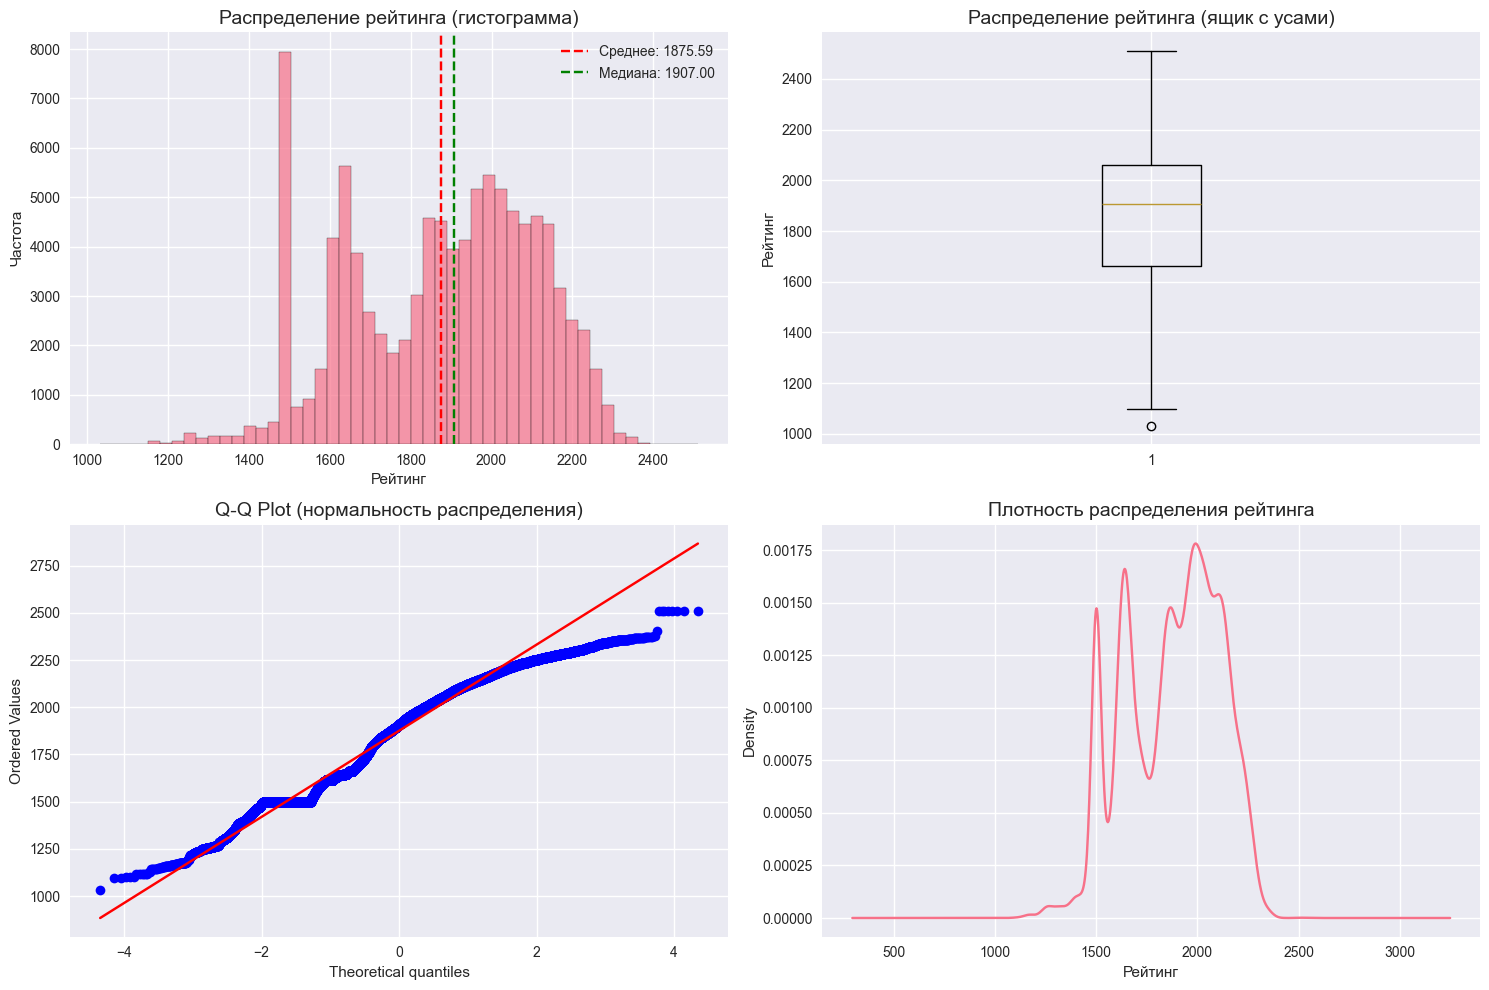

In [5]:
# Distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(train_df['rating'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение рейтинга (гистограмма)', fontsize=14)
axes[0, 0].set_xlabel('Рейтинг')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].axvline(train_df['rating'].mean(), color='r', linestyle='--', label=f'Среднее: {train_df["rating"].mean():.2f}')
axes[0, 0].axvline(train_df['rating'].median(), color='g', linestyle='--', label=f'Медиана: {train_df["rating"].median():.2f}')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(train_df['rating'], vert=True)
axes[0, 1].set_title('Распределение рейтинга (ящик с усами)', fontsize=14)
axes[0, 1].set_ylabel('Рейтинг')

# Q-Q plot
from scipy import stats
stats.probplot(train_df['rating'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (нормальность распределения)', fontsize=14)

# Density plot
train_df['rating'].plot(kind='density', ax=axes[1, 1])
axes[1, 1].set_title('Плотность распределения рейтинга', fontsize=14)
axes[1, 1].set_xlabel('Рейтинг')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# This cell was moved - feature_types classification now happens in the outlier analysis cell (cell 17)

In [7]:
# Outlier detection using IQR method
Q1 = train_df['rating'].quantile(0.25)
Q3 = train_df['rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['rating'] < lower_bound) | (train_df['rating'] > upper_bound)]
print(f"=== Анализ аномальных значений ===")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")
print(f"Количество аномальных значений: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}%)")

if len(outliers) > 0:
    print(f"\nМинимальное значение: {train_df['rating'].min():.2f}")
    print(f"Максимальное значение: {train_df['rating'].max():.2f}")


=== Анализ аномальных значений ===
Q1: 1664.00
Q3: 2060.00
IQR: 396.00
Нижняя граница: 1070.00
Верхняя граница: 2654.00
Количество аномальных значений: 1 (0.00%)

Минимальное значение: 1033.00
Максимальное значение: 2510.00


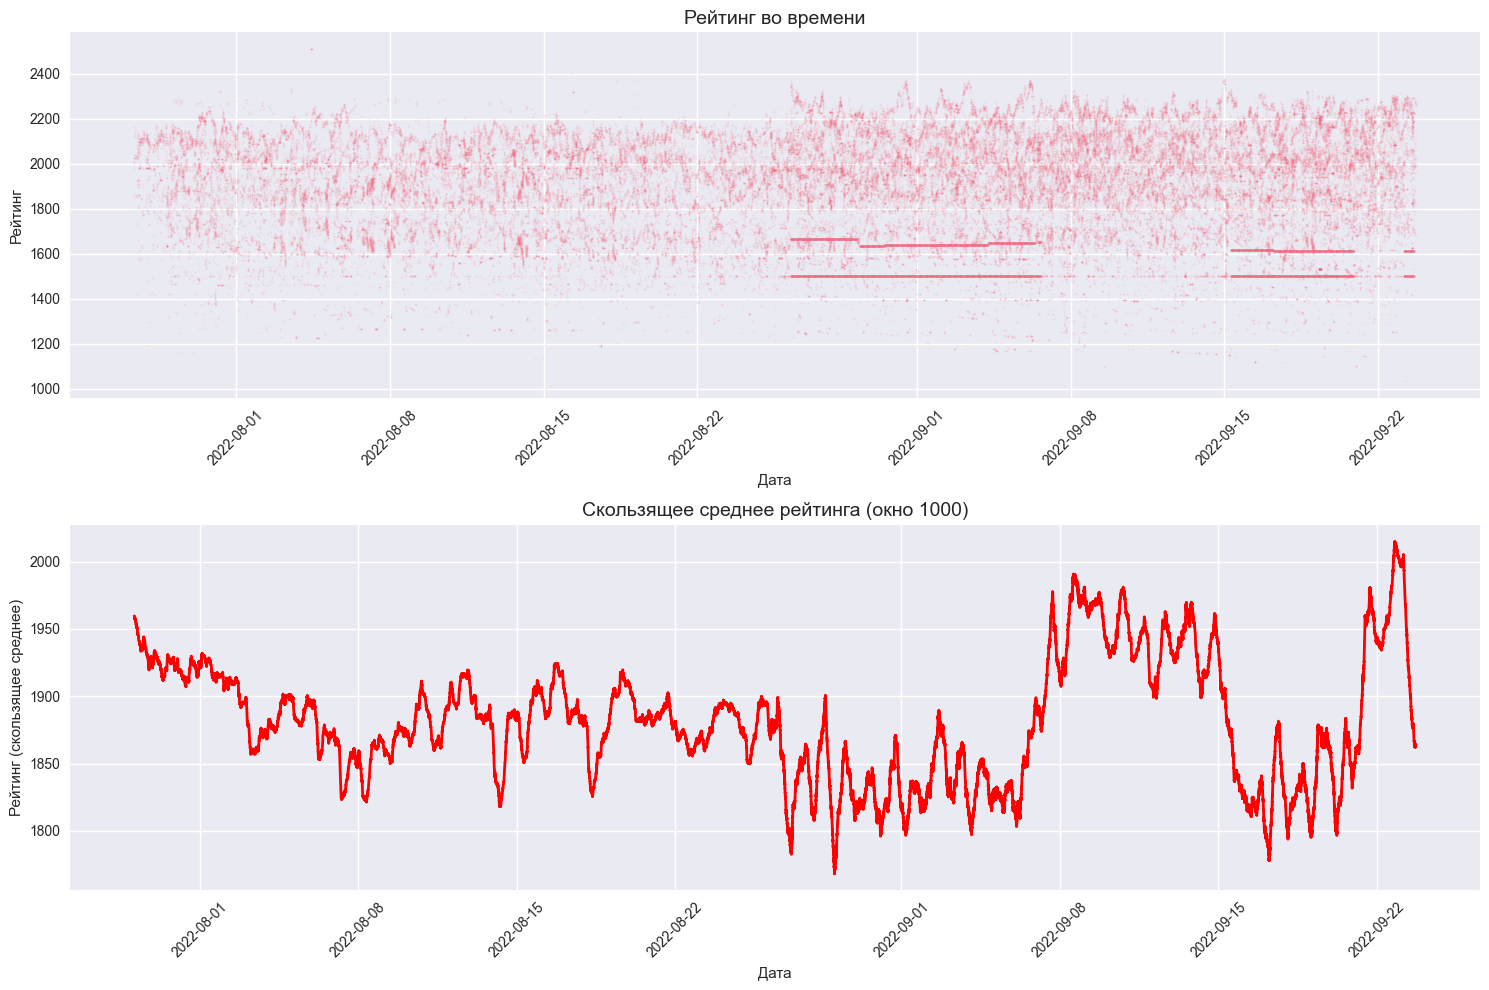

In [8]:
# Temporal analysis if 'created_at' exists in games_df
if 'created_at' in games_df.columns:
    # Merge to get ratings over time
    train_with_time = train_df.merge(games_df[['game_id', 'created_at']], on='game_id', how='left')
    train_with_time['created_at'] = pd.to_datetime(train_with_time['created_at'])
    train_with_time = train_with_time.sort_values('created_at')
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Rating over time
    axes[0].scatter(train_with_time['created_at'], train_with_time['rating'], alpha=0.1, s=1)
    axes[0].set_title('Рейтинг во времени', fontsize=14)
    axes[0].set_xlabel('Дата')
    axes[0].set_ylabel('Рейтинг')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Rolling mean
    train_with_time['rating_rolling_mean'] = train_with_time['rating'].rolling(window=1000).mean()
    axes[1].plot(train_with_time['created_at'], train_with_time['rating_rolling_mean'], color='red', linewidth=2)
    axes[1].set_title('Скользящее среднее рейтинга (окно 1000)', fontsize=14)
    axes[1].set_xlabel('Дата')
    axes[1].set_ylabel('Рейтинг (скользящее среднее)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'target_temporal.png', dpi=300, bbox_inches='tight')
    plt.show()


<a id='4'></a>
## 4. Анализ признаков


In [9]:
# Import utility functions
import sys
sys.path.append(str(PROJECT_ROOT / 'src'))
from utils.feature_engineering import aggregate_turns_features, classify_features, create_additional_features

# Create aggregated features
turns_features = aggregate_turns_features(turns_df)
print(f"Turns features shape: {turns_features.shape}")
print(turns_features.head())


Turns features shape: (145546, 13)
   game_id   nickname  num_turns  avg_points_per_turn  total_points  \
0        1  BetterBot         13            25.769231           335   
1        1      stevy         14            30.642857           429   
2        2  BetterBot         12            33.416667           401   
3        2      Super         14            34.857143           488   
4        3  BetterBot         13            24.461538           318   

   max_points_single_turn  min_points_single_turn  std_points  final_score  \
0                      68                       8   16.457794          335   
1                      98                       2   25.490895          429   
2                      85                       8   25.564387          401   
3                      94                       0   30.866604          488   
4                      76                       0   18.058310          318   

   num_plays  num_exchanges  num_passes  avg_rack_length  
0         

In [10]:
# Merge all data
train_merged = (
    train_df
    .merge(games_df, on='game_id', how='left')
    .merge(turns_features, on=['game_id', 'nickname'], how='left')
)

print(f"Merged train shape: {train_merged.shape}")
print(f"\nColumns: {list(train_merged.columns)}")


Merged train shape: (100820, 26)

Columns: ['game_id', 'nickname', 'score', 'rating', 'first', 'time_control_name', 'game_end_reason', 'winner', 'created_at', 'lexicon', 'initial_time_seconds', 'increment_seconds', 'rating_mode', 'max_overtime_minutes', 'game_duration_seconds', 'num_turns', 'avg_points_per_turn', 'total_points', 'max_points_single_turn', 'min_points_single_turn', 'std_points', 'final_score', 'num_plays', 'num_exchanges', 'num_passes', 'avg_rack_length']


#### 4.2. Выявление аномальных значений в признаках


=== Анализ аномальных значений в признаках ===

Признаки с аномальными значениями:
                   Feature  Outliers    Percent         Min          Max  \
1     initial_time_seconds     18848  18.694703   15.000000  3600.000000   
6   max_points_single_turn     10001   9.919659    0.000000   302.000000   
7   min_points_single_turn      5471   5.426503 -221.000000    43.000000   
2    game_duration_seconds      3482   3.453680   19.764543  4444.821645   
8               std_points      2969   2.944852    0.000000    92.877021   
0                    score      1944   1.928189  -64.000000  1132.000000   
5             total_points      1944   1.928189  -64.000000  1132.000000   
9              final_score      1944   1.928189  -64.000000  1132.000000   
4      avg_points_per_turn      1459   1.447134   -4.000000    84.000000   
3                num_turns      1218   1.208094    9.000000    43.000000   
10               num_plays      1129   1.119817    0.000000    28.000000   

    

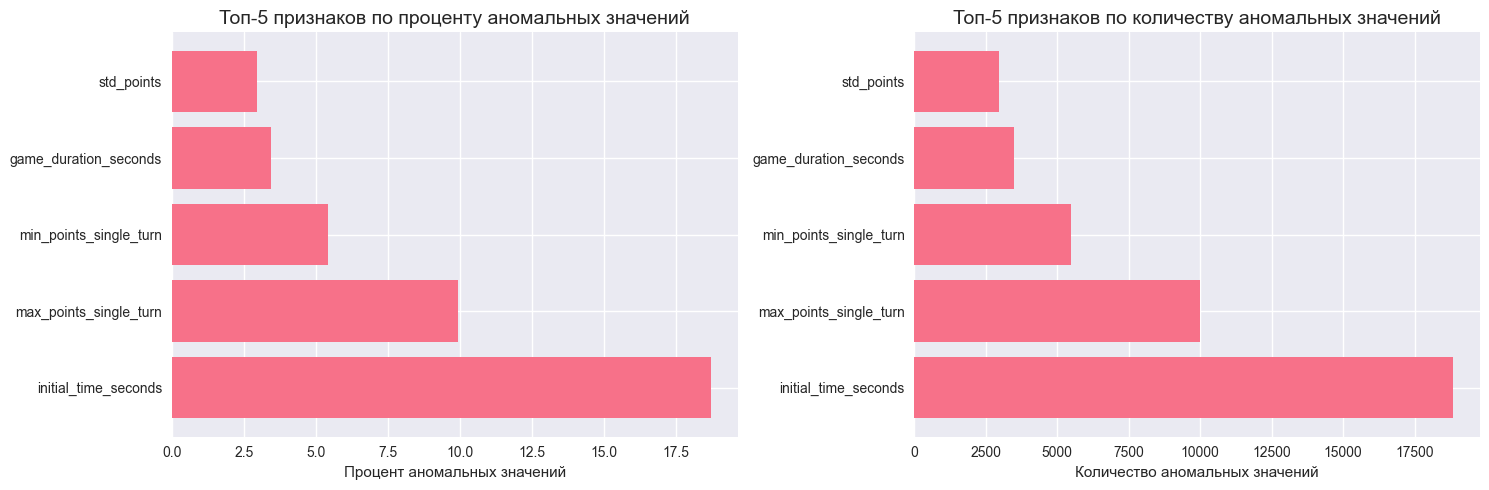

In [11]:
# Анализ аномальных значений в числовых признаках
print("=== Анализ аномальных значений в признаках ===")

# Classify features if not already done
if 'feature_types' not in globals() or feature_types is None:
    feature_types = classify_features(train_merged)

numeric_cols_for_outliers = feature_types['numeric'][:15]  # Первые 15 числовых признаков

outlier_summary = []
for col in numeric_cols_for_outliers:
    if col in train_merged.columns:
        Q1 = train_merged[col].quantile(0.25)
        Q3 = train_merged[col].quantile(0.75)
        IQR = Q3 - Q1
        
        if IQR > 0:  # Избегаем деления на ноль
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers_count = ((train_merged[col] < lower_bound) | (train_merged[col] > upper_bound)).sum()
            outlier_percent = (outliers_count / len(train_merged)) * 100
            
            if outliers_count > 0:
                outlier_summary.append({
                    'Feature': col,
                    'Outliers': outliers_count,
                    'Percent': outlier_percent,
                    'Min': train_merged[col].min(),
                    'Max': train_merged[col].max(),
                    'Lower_bound': lower_bound,
                    'Upper_bound': upper_bound
                })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\nПризнаки с аномальными значениями:")
    print(outlier_df.sort_values('Percent', ascending=False))
    
    # Визуализация топ-5 признаков с наибольшим процентом аномалий
    top_outliers = outlier_df.nlargest(5, 'Percent')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Процент аномалий
    axes[0].barh(top_outliers['Feature'], top_outliers['Percent'])
    axes[0].set_title('Топ-5 признаков по проценту аномальных значений', fontsize=14)
    axes[0].set_xlabel('Процент аномальных значений')
    
    # Количество аномалий
    axes[1].barh(top_outliers['Feature'], top_outliers['Outliers'])
    axes[1].set_title('Топ-5 признаков по количеству аномальных значений', fontsize=14)
    axes[1].set_xlabel('Количество аномальных значений')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'feature_outliers.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Аномальные значения не обнаружены в анализируемых признаках")


In [12]:
# Feature type classification
feature_types = classify_features(train_merged)
print("=== Классификация признаков ===")
print(f"Числовые признаки ({len(feature_types['numeric'])}): {feature_types['numeric']}")
print(f"\nКатегориальные признаки ({len(feature_types['categorical'])}): {feature_types['categorical']}")
print(f"\nВременные признаки ({len(feature_types['datetime'])}): {feature_types['datetime']}")


=== Классификация признаков ===
Числовые признаки (18): ['game_id', 'score', 'winner', 'initial_time_seconds', 'increment_seconds', 'max_overtime_minutes', 'game_duration_seconds', 'num_turns', 'avg_points_per_turn', 'total_points', 'max_points_single_turn', 'min_points_single_turn', 'std_points', 'final_score', 'num_plays', 'num_exchanges', 'num_passes', 'avg_rack_length']

Категориальные признаки (6): ['nickname', 'first', 'game_end_reason', 'created_at', 'lexicon', 'rating_mode']

Временные признаки (1): ['time_control_name']


In [13]:
# Missing values analysis
missing_values = train_merged.isnull().sum()
missing_percent = (missing_values / len(train_merged)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percent': missing_percent
}).sort_values('Missing Count', ascending=False)

print("=== Анализ пропущенных значений ===")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualization
if missing_df['Missing Count'].sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_df[missing_df['Missing Count'] > 0]['Missing Percent'].plot(kind='barh')
    plt.title('Процент пропущенных значений по признакам', fontsize=14)
    plt.xlabel('Процент пропущенных значений')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Анализ пропущенных значений ===
Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []


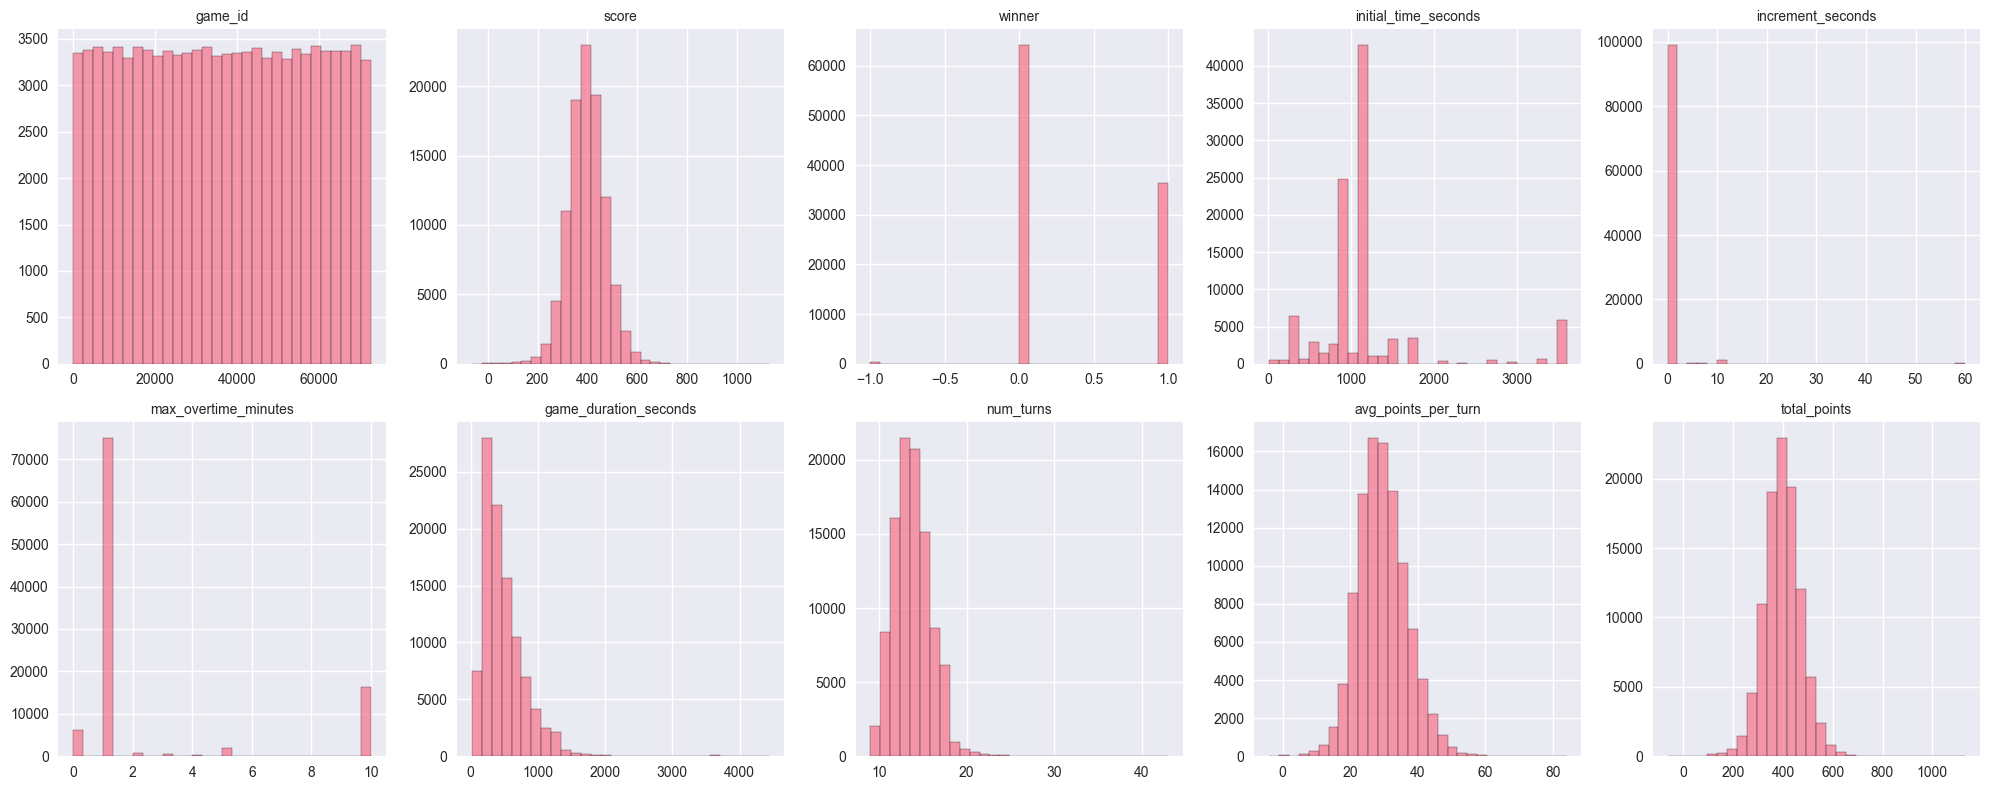

In [14]:
# Feature distributions visualization
numeric_cols = feature_types['numeric'][:10]  # First 10 numeric features

if len(numeric_cols) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            train_merged[col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{col}', fontsize=10)
            axes[idx].set_xlabel('')
            axes[idx].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'numeric_features_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Корреляция признаков с целевой переменной ===
rating                    1.000000
avg_points_per_turn       0.465008
final_score               0.425136
score                     0.425136
total_points              0.425136
max_points_single_turn    0.216420
min_points_single_turn    0.172253
std_points                0.168454
game_duration_seconds     0.150011
initial_time_seconds      0.149568
avg_rack_length           0.025961
increment_seconds         0.005766
winner                    0.003908
game_id                   0.002249
num_passes               -0.044494
num_exchanges            -0.155796
num_plays                -0.229278
num_turns                -0.237326
max_overtime_minutes     -0.434311
Name: rating, dtype: float64


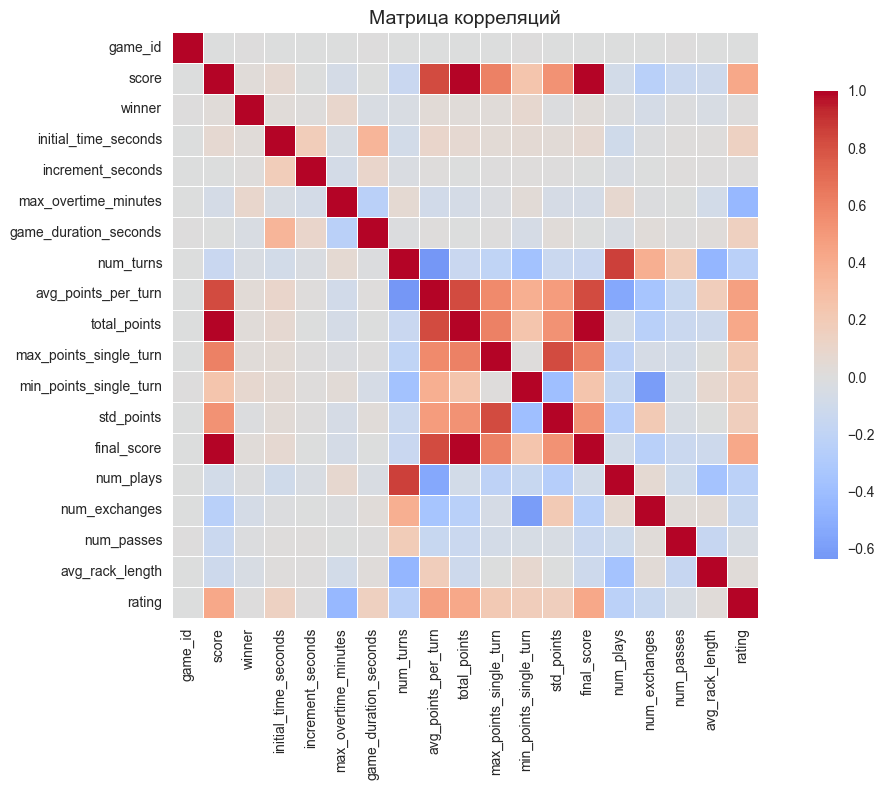

In [15]:
# Correlation analysis
numeric_cols_all = feature_types['numeric']
correlation_matrix = train_merged[numeric_cols_all + ['rating']].corr()

# Correlation with target
target_corr = correlation_matrix['rating'].sort_values(ascending=False)
print("=== Корреляция признаков с целевой переменной ===")
print(target_corr)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=14)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


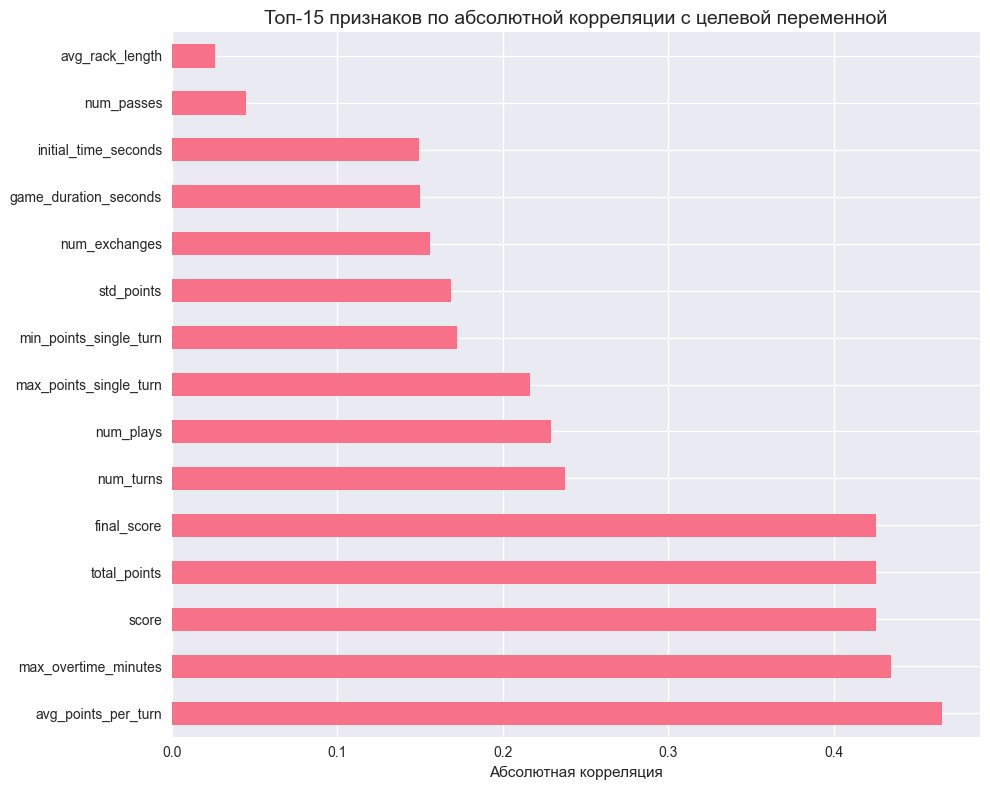

In [16]:
# Feature importance visualization (top correlations)
top_corr = target_corr.drop('rating').abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
top_corr.plot(kind='barh')
plt.title('Топ-15 признаков по абсолютной корреляции с целевой переменной', fontsize=14)
plt.xlabel('Абсолютная корреляция')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'feature_importance_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


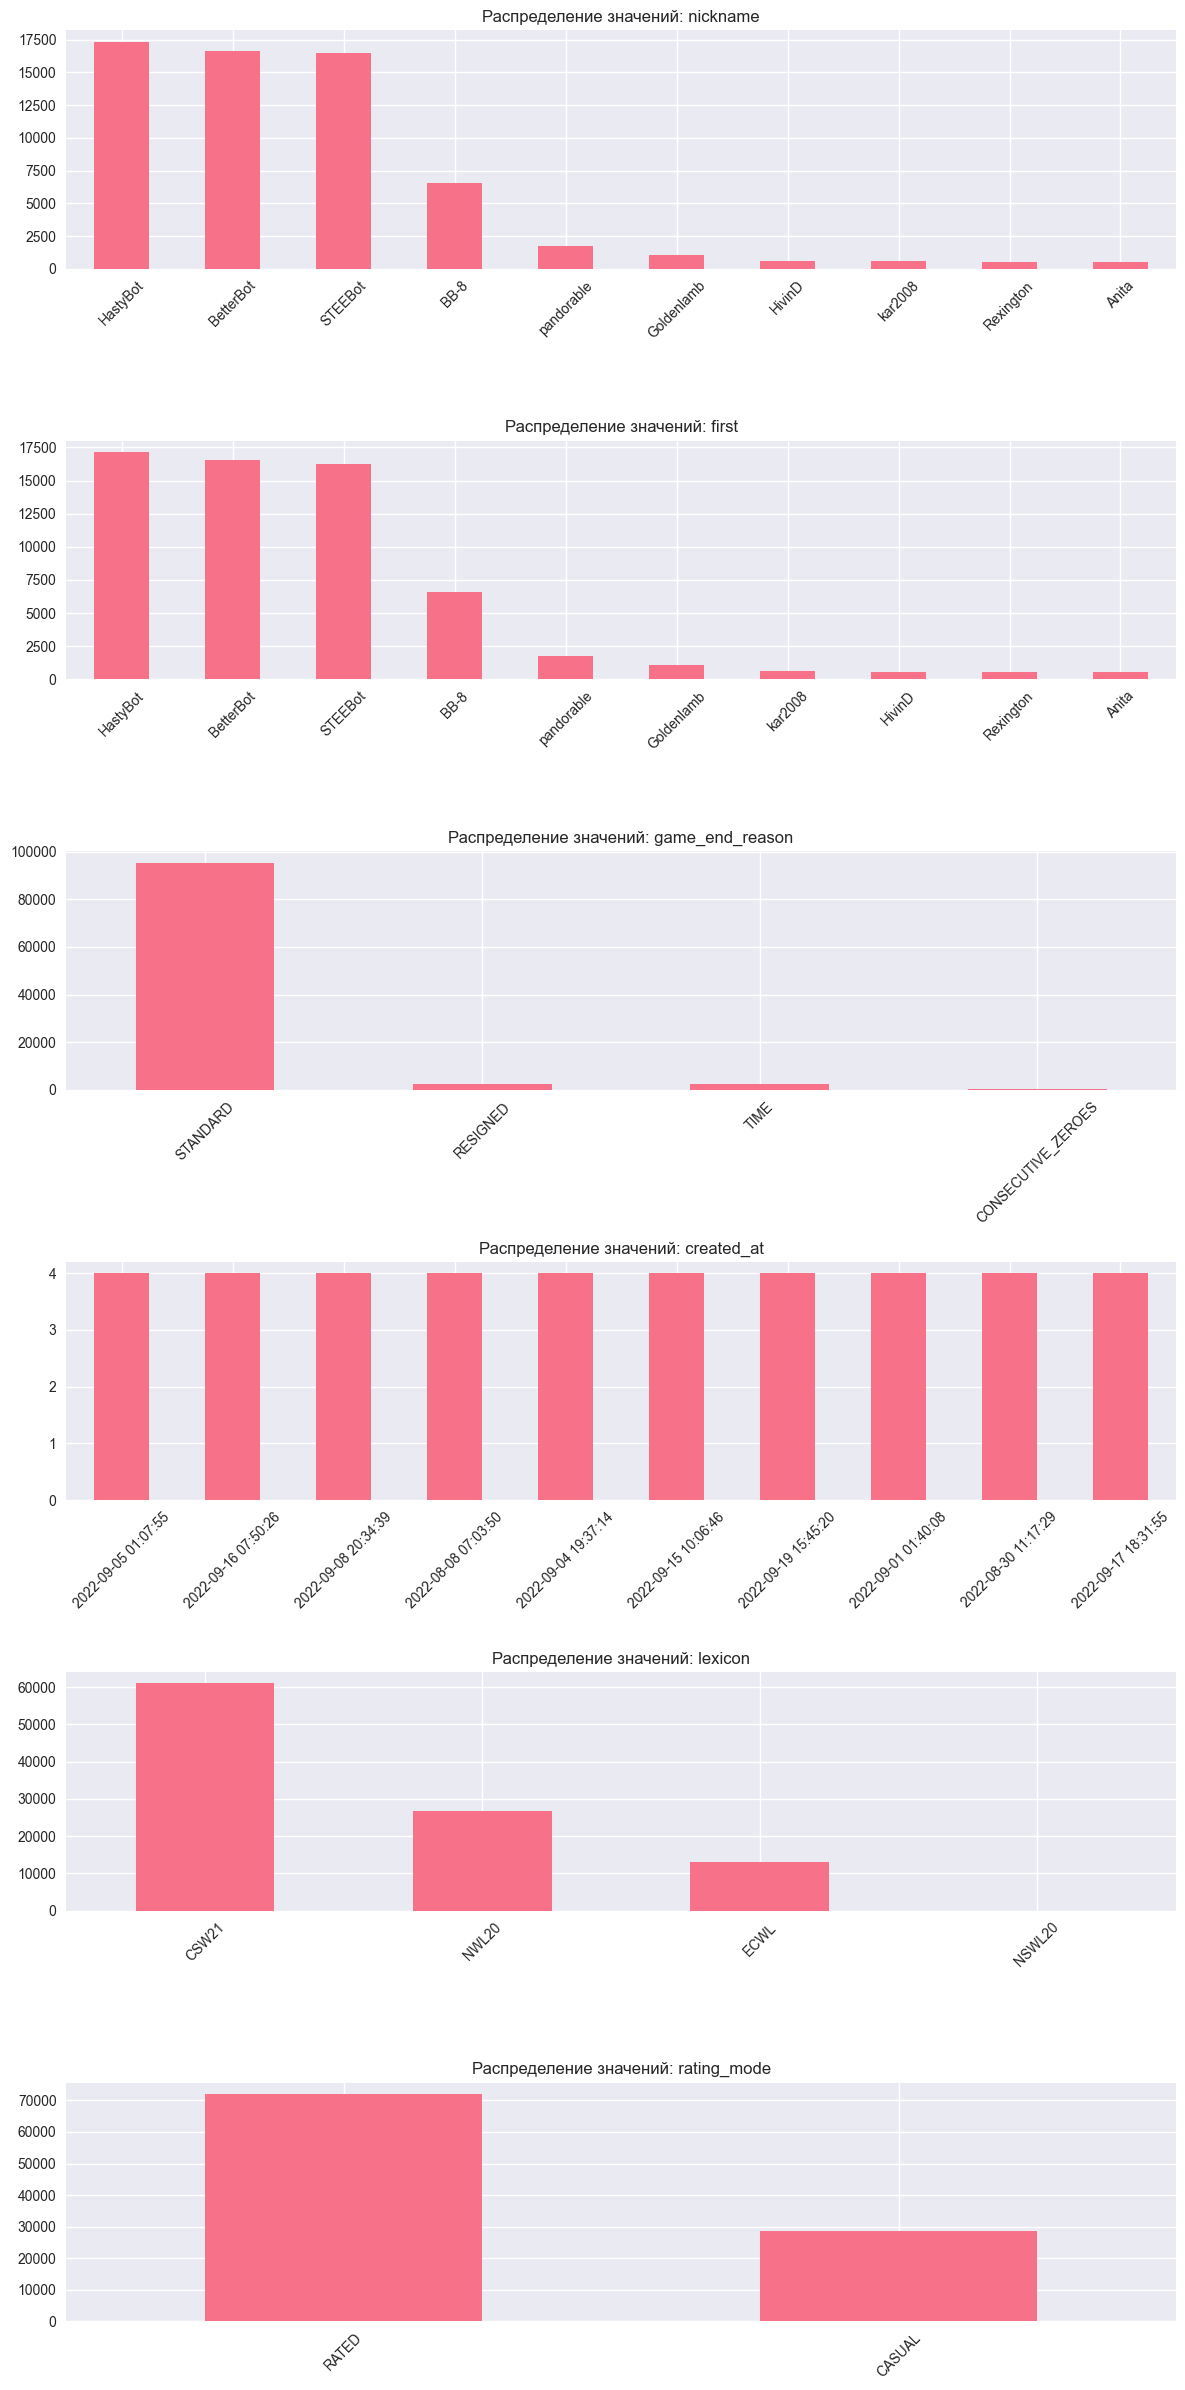

In [17]:
# Categorical features analysis
categorical_cols = feature_types['categorical']

if len(categorical_cols) > 0:
    fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 4 * len(categorical_cols)))
    if len(categorical_cols) == 1:
        axes = [axes]
    
    for idx, col in enumerate(categorical_cols):
        value_counts = train_merged[col].value_counts().head(10)
        value_counts.plot(kind='bar', ax=axes[idx])
        axes[idx].set_title(f'Распределение значений: {col}', fontsize=12)
        axes[idx].set_xlabel('')
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'categorical_features_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


<a id='5'></a>
## 5. Бейзлайн с LightAutoML

Создадим минимум 2 различные конфигурации и выберем лучшую.


In [18]:
# Prepare data for LightAutoML
# Remove target and ID columns
feature_cols = [col for col in train_merged.columns 
                if col not in ['rating', 'game_id', 'nickname']]

X_train = train_merged[feature_cols].copy()
y_train = train_merged['rating'].copy()

# Handle missing values
X_train = X_train.fillna(0)

# Split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train shape: {X_train_split.shape}")
print(f"Validation shape: {X_val_split.shape}")


Train shape: (80656, 23)
Validation shape: (20164, 23)


In [19]:
# Configuration 1: Default TabularAutoML
print("=== Конфигурация 1: TabularAutoML (default) ===")

task1 = Task('reg', metric='mse')
automl1 = TabularAutoML(
    task=task1,
    timeout=240,  # 4 minutes
    cpu_limit=N_THREADS,
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]}
)

train_data_1 = pd.concat([X_train_split, y_train_split], axis=1)
train_data_1.columns = list(X_train_split.columns) + ['rating']

start_time = time.time()
oof_pred1 = automl1.fit_predict(
    train_data_1,
    roles={'target': 'rating'},
    verbose=1
)
time1 = time.time() - start_time

val_pred1 = automl1.predict(X_val_split)
rmse1 = np.sqrt(mean_squared_error(y_val_split, val_pred1.data[:, 0]))
mae1 = mean_absolute_error(y_val_split, val_pred1.data[:, 0])
r2_1 = r2_score(y_val_split, val_pred1.data[:, 0])

print(f"\nВремя обучения: {time1:.2f} секунд")
print(f"RMSE: {rmse1:.4f}")
print(f"MAE: {mae1:.4f}")
print(f"R2 Score: {r2_1:.4f}")


=== Конфигурация 1: TabularAutoML (default) ===
[15:23:40] Stdout logging level is INFO.
[15:23:40] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[15:23:40] Task: reg

[15:23:40] Start automl preset with listed constraints:
[15:23:40] - time: 240.00 seconds
[15:23:40] - CPU: 4 cores
[15:23:40] - memory: 16 GB

[15:23:40] Train data shape: (80656, 24)

[15:23:43] Layer 1 train process start. Time left 236.72 secs
[15:23:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:24:12] Time limit exceeded after calculating fold 3

[15:24:12] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16849.890625
[15:24:12] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:24:12] Time left 208.61 secs

[15:24:13] Selector_LightGBM fitting and predicting completed
[15:24:14] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:24:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -21893.287109375
[15:24:31] Lvl_0_Pipe_1_Mod_0_L

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-17 15:24:31,818 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-06d706d7-2b18-4b71-90c0-960c548a41a4
2025-12-17 15:24:40,549 - optuna.study.study - INFO - Trial 0 finished with value: -21172.388671875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -21172.388671875.
Optimization Progress:   9%|▉         | 9/101 [01:15<12:55,  8.43s/it, best_trial=3, best_value=-2.11e+4]

[15:25:47] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:25:47] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[15:26:10] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -21929.216796875
[15:26:10] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:26:10] Time left 90.18 secs

[15:26:10] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[15:26:10] Layer 1 training completed.

[15:26:10] Blending: optimization starts with equal weights. Score = -18185.1640625
[15:26:10] Blending: iteration 0: score = -16884.8925781, weights = [0.68394166 0.15248172 0.16357663]
[15:26:10] Blending: iteration 1: score = -16884.6230469, weights = [0.6848961  0.14799279 0.16711107]
[15:26:10] Blending: iteration 2: score = -16884.4492188, weights = [0.6849134  0.14433807 0.17074844]
[15:26:10] Blending: iteration 3: score = -16884.3300781, weights = [0.68504816 0.14130847 0.17364337]
[15:26:10] Blending: iteration 4: score = -16884.2460938, weights = [0.6856662  0.13885428 0.17547946]
[15:26:10] Blending: best score = -16884.2460938, best weights = [0.6856662

In [20]:
# Configuration 2: TabularAutoML with more algorithms
print("=== Конфигурация 2: TabularAutoML (extended algorithms) ===")

task2 = Task('reg', metric='mse')
automl2 = TabularAutoML(
    task=task2,
    timeout=360,  # 6 minutes
    cpu_limit=N_THREADS,
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
)

train_data_2 = pd.concat([X_train_split, y_train_split], axis=1)
train_data_2.columns = list(X_train_split.columns) + ['rating']

start_time = time.time()
oof_pred2 = automl2.fit_predict(
    train_data_2,
    roles={'target': 'rating'},
    verbose=1
)
time2 = time.time() - start_time

val_pred2 = automl2.predict(X_val_split)
rmse2 = np.sqrt(mean_squared_error(y_val_split, val_pred2.data[:, 0]))
mae2 = mean_absolute_error(y_val_split, val_pred2.data[:, 0])
r2_2 = r2_score(y_val_split, val_pred2.data[:, 0])

print(f"\nВремя обучения: {time2:.2f} секунд")
print(f"RMSE: {rmse2:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"R2 Score: {r2_2:.4f}")


=== Конфигурация 2: TabularAutoML (extended algorithms) ===
[15:26:13] Stdout logging level is INFO.
[15:26:13] Task: reg

[15:26:13] Start automl preset with listed constraints:
[15:26:13] - time: 360.00 seconds
[15:26:13] - CPU: 4 cores
[15:26:13] - memory: 16 GB

[15:26:13] Train data shape: (80656, 24)

[15:26:13] Layer 1 train process start. Time left 359.29 secs
[15:26:15] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:26:31] Time limit exceeded after calculating fold 2

[15:26:31] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16743.19140625
[15:26:31] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:26:31] Time left 341.26 secs

[15:26:34] Selector_LightGBM fitting and predicting completed
[15:26:34] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:26:51] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -21893.287109375
[15:26:51] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:26:51] Start hyperparameters optimization for Lvl_0

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-17 15:26:51,978 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-3893f803-2fa0-46a4-aa40-469c883fa960
2025-12-17 15:27:01,032 - optuna.study.study - INFO - Trial 0 finished with value: -21172.388671875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -21172.388671875.
Optimization Progress:   2%|▏         | 2/101 [00:18<15:37,  9.47s/it, best_trial=0, best_value=-2.12e+4]

[15:27:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:27:10] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[15:27:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -21919.3203125
[15:27:39] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:27:40] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:27:58] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -22077.677734375
[15:27:58] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:27:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 132.64 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-17 15:27:58,025 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-e2272c9f-3470-4b2a-964d-b16671891c71
2025-12-17 15:28:01,240 - optuna.study.study - INFO - Trial 0 finished with value: -21785.486328125 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -21785.486328125.
Optimization Progress:  33%|███▎      | 33/101 [02:15<04:39,  4.12s/it, best_trial=13, best_value=-2.1e+4]

[15:30:13] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[15:30:13] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[15:30:41] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -21860.0234375
[15:30:41] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[15:30:41] Time left 91.91 secs

[15:30:41] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[15:30:41] Layer 1 training completed.

[15:30:41] Blending: optimization starts with equal weights. Score = -19851.7441406
[15:30:41] Blending: iteration 0: score = -18039.7597656, weights = [0.6747042  0.07867342 0.10953729 0.05560438 0.08148068]
[15:30:41] Blending: iteration 1: score = -18022.7246094, weights = [0.6747377  0.06883173 0.12562299 0.         0.13080755]
[15:30:41] Blending: iteration 2: score = -18022.6835938, weights = [0.67697793 0.06835766 0.12475777 0.         0.12990662]
[15:30:41] Blending: no improvements for score. Terminated.

[15:30:41] Blending: best score = -18022.6835938, best weights = [0.67697793 0.06835766 0.12475777 0.         0.12990662]
[15:30:41] Automl preset training 

In [21]:
# Compare configurations
comparison_df = pd.DataFrame({
    'Configuration': ['Config 1 (LGB)', 'Config 2 (LGB + CB)'],
    'RMSE': [rmse1, rmse2],
    'MAE': [mae1, mae2],
    'R2 Score': [r2_1, r2_2],
    'Time (seconds)': [time1, time2]
})

print("=== Сравнение конфигураций LightAutoML ===")
print(comparison_df)

# Select best model
best_config_idx = comparison_df['RMSE'].idxmin()
best_automl = automl1 if best_config_idx == 0 else automl2
best_rmse = comparison_df.loc[best_config_idx, 'RMSE']

print(f"\nЛучшая конфигурация: {comparison_df.loc[best_config_idx, 'Configuration']}")
print(f"Лучший RMSE: {best_rmse:.4f}")


=== Сравнение конфигураций LightAutoML ===
         Configuration        RMSE        MAE  R2 Score  Time (seconds)
0       Config 1 (LGB)  124.884368  95.471016  0.708805      149.944235
1  Config 2 (LGB + CB)  124.775431  95.365952  0.709313      268.300451

Лучшая конфигурация: Config 2 (LGB + CB)
Лучший RMSE: 124.7754


<a id='6'></a>
## 6. Собственное решение

Создадим собственный пайплайн без использования LightAutoML, демонстрируя принципы AutoML:

1. **Автоматический выбор признаков** - автоматический отбор наиболее информативных признаков
2. **Автоматическая предобработка** - обработка пропусков, кодирование категориальных переменных
3. **Автоматический выбор модели** - сравнение нескольких алгоритмов и выбор лучшего
4. **Автоматическая оптимизация гиперпараметров** - поиск оптимальных параметров модели
5. **Автоматическое ансамблирование** - комбинирование нескольких моделей с оптимизацией весов


In [22]:
# Create enhanced features
train_enhanced = create_additional_features(train_df, games_df, turns_features)
print(f"Enhanced train shape: {train_enhanced.shape}")


Enhanced train shape: (100820, 32)


In [23]:
# Prepare data for custom pipeline
feature_cols_enhanced = [col for col in train_enhanced.columns 
                        if col not in ['rating', 'game_id', 'nickname']]

X_train_custom = train_enhanced[feature_cols_enhanced].copy()
y_train_custom = train_enhanced['rating'].copy()

# Split data
X_train_custom_split, X_val_custom_split, y_train_custom_split, y_val_custom_split = train_test_split(
    X_train_custom, y_train_custom, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Custom train shape: {X_train_custom_split.shape}")
print(f"Custom validation shape: {X_val_custom_split.shape}")


Custom train shape: (80656, 29)
Custom validation shape: (20164, 29)


In [24]:
# Pipeline 1: LightGBM with feature selection
# AutoML принцип: Автоматический выбор признаков (Feature Selection)
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import numpy as np

print("=== Pipeline 1: LightGBM с автоматическим отбором признаков ===")
print("Принцип AutoML: Автоматический выбор наиболее информативных признаков")

# Обработка категориальных признаков перед feature selection
categorical_cols_p1 = [col for col in X_train_custom_split.columns 
                       if X_train_custom_split[col].dtype == 'object']

# Кодируем категориальные признаки
X_train_encoded_p1 = X_train_custom_split.copy()
X_val_encoded_p1 = X_val_custom_split.copy()

label_encoders_p1 = {}
for col in categorical_cols_p1:
    le = LabelEncoder()
    # train
    train_col = X_train_encoded_p1[col].astype(str).fillna('unknown')
    le.fit(train_col)
    # гарантируем наличие 'unknown' в классах
    if 'unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'unknown')
    X_train_encoded_p1[col] = le.transform(train_col)

    # val: неизвестные значения мапим в 'unknown'
    val_col = X_val_encoded_p1[col].astype(str).fillna('unknown')
    known = set(le.classes_)
    val_col = val_col.apply(lambda x: x if x in known else 'unknown')
    X_val_encoded_p1[col] = le.transform(val_col)

    label_encoders_p1[col] = le

# Заполняем пропуски
X_train_encoded_p1 = X_train_encoded_p1.fillna(0)
X_val_encoded_p1 = X_val_encoded_p1.fillna(0)

# Используем только числовые признаки (без дат и категориальных)
X_train_num_p1 = X_train_encoded_p1.select_dtypes(include=[np.number])
X_val_num_p1 = X_val_encoded_p1.select_dtypes(include=[np.number])

# Автоматический выбор признаков - пробуем разные методы
# Метод 1: F-статистика
selector_f = SelectKBest(f_regression, k=50)
X_train_f = selector_f.fit_transform(X_train_num_p1, y_train_custom_split)

# Метод 2: Mutual Information
try:
    selector_mi = SelectKBest(mutual_info_regression, k=50)
    X_train_mi = selector_mi.fit_transform(X_train_num_p1, y_train_custom_split)
    
    # Выбираем лучший метод на основе кросс-валидации
    from sklearn.model_selection import cross_val_score
    temp_model = LGBMRegressor(n_estimators=100, random_state=RANDOM_STATE, verbose=-1)
    
    score_f = cross_val_score(temp_model, X_train_f, y_train_custom_split, 
                              cv=3, scoring='neg_mean_squared_error').mean()
    score_mi = cross_val_score(temp_model, X_train_mi, y_train_custom_split, 
                               cv=3, scoring='neg_mean_squared_error').mean()
    
    if score_mi > score_f:
        selector = selector_mi
        print(f"Выбран метод: Mutual Information (score: {score_mi:.4f})")
    else:
        selector = selector_f
        print(f"Выбран метод: F-regression (score: {score_f:.4f})")
except:
    selector = selector_f
    print("Используется метод: F-regression")

X_train_selected = selector.fit_transform(X_train_num_p1, y_train_custom_split)
X_val_selected = selector.transform(X_val_num_p1)

# Model
model1 = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=RANDOM_STATE,
    n_jobs=N_THREADS,
    verbose=-1
)

start_time = time.time()
model1.fit(X_train_selected, y_train_custom_split)
time_p1 = time.time() - start_time

val_pred_p1 = model1.predict(X_val_selected)
rmse_p1 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p1))
mae_p1 = mean_absolute_error(y_val_custom_split, val_pred_p1)
r2_p1 = r2_score(y_val_custom_split, val_pred_p1)

print(f"Время обучения: {time_p1:.2f} секунд")
print(f"RMSE: {rmse_p1:.4f}")
print(f"MAE: {mae_p1:.4f}")
print(f"R2 Score: {r2_p1:.4f}")


=== Pipeline 1: LightGBM с автоматическим отбором признаков ===
Принцип AutoML: Автоматический выбор наиболее информативных признаков
Выбран метод: F-regression (score: -11626.6464)
Время обучения: 1.32 секунд
RMSE: 106.5994
MAE: 77.7689
R2 Score: 0.7878


In [25]:
# Pipeline 2: CatBoost with preprocessing
# AutoML принцип: Автоматическая предобработка данных
from catboost import CatBoostRegressor

print("=== Pipeline 2: CatBoost с автоматической предобработкой ===")
print("Принцип AutoML: Автоматическая обработка категориальных признаков и пропусков")

# Identify categorical columns
categorical_cols_custom = [col for col in X_train_custom_split.columns 
                           if X_train_custom_split[col].dtype == 'object']

# Encode categorical variables
label_encoders = {}
X_train_encoded = X_train_custom_split.copy()
X_val_encoded = X_val_custom_split.copy()

for col in categorical_cols_custom:
    le = LabelEncoder()
    # train
    train_col = X_train_encoded[col].astype(str).fillna('unknown')
    le.fit(train_col)
    # гарантируем наличие 'unknown' в классах
    if 'unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'unknown')
    X_train_encoded[col] = le.transform(train_col)

    # val: неизвестные значения мапим в 'unknown'
    val_col = X_val_encoded[col].astype(str).fillna('unknown')
    known = set(le.classes_)
    val_col = val_col.apply(lambda x: x if x in known else 'unknown')
    X_val_encoded[col] = le.transform(val_col)

    label_encoders[col] = le

# Fill missing values
X_train_encoded = X_train_encoded.fillna(0)
X_val_encoded = X_val_encoded.fillna(0)

# Model
model2 = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=7,
    random_state=RANDOM_STATE,
    thread_count=N_THREADS,
    verbose=False
)

start_time = time.time()
model2.fit(X_train_encoded, y_train_custom_split)
time_p2 = time.time() - start_time

val_pred_p2 = model2.predict(X_val_encoded)
rmse_p2 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p2))
mae_p2 = mean_absolute_error(y_val_custom_split, val_pred_p2)
r2_p2 = r2_score(y_val_custom_split, val_pred_p2)

print(f"Время обучения: {time_p2:.2f} секунд")
print(f"RMSE: {rmse_p2:.4f}")
print(f"MAE: {mae_p2:.4f}")
print(f"R2 Score: {r2_p2:.4f}")


=== Pipeline 2: CatBoost с автоматической предобработкой ===
Принцип AutoML: Автоматическая обработка категориальных признаков и пропусков
Время обучения: 1.41 секунд
RMSE: 109.1741
MAE: 79.6370
R2 Score: 0.7775


In [26]:
# Pipeline 3: Ensemble (LightGBM + CatBoost)
# AutoML принцип: Ансамблирование моделей
print("=== Pipeline 3: Простой ансамбль (LightGBM + CatBoost) ===")
print("Принцип AutoML: Комбинирование нескольких моделей для улучшения предсказаний")

# Use the same preprocessing as Pipeline 2
# Используем только числовые признаки (исключаем datetime)
X_train_encoded_num = X_train_encoded.select_dtypes(include=[np.number])
X_val_encoded_num = X_val_encoded.select_dtypes(include=[np.number])

model_lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=RANDOM_STATE,
    n_jobs=N_THREADS,
    verbose=-1
)

model_cat = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=7,
    random_state=RANDOM_STATE + 1,
    thread_count=N_THREADS,
    verbose=False
)

start_time = time.time()
model_lgb.fit(X_train_encoded_num, y_train_custom_split)
model_cat.fit(X_train_encoded_num, y_train_custom_split)
time_p3 = time.time() - start_time

val_pred_lgb = model_lgb.predict(X_val_encoded_num)
val_pred_cat = model_cat.predict(X_val_encoded_num)
val_pred_p3 = (val_pred_lgb + val_pred_cat) / 2  # Simple average

rmse_p3 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p3))
mae_p3 = mean_absolute_error(y_val_custom_split, val_pred_p3)
r2_p3 = r2_score(y_val_custom_split, val_pred_p3)

print(f"Время обучения: {time_p3:.2f} секунд")
print(f"RMSE: {rmse_p3:.4f}")
print(f"MAE: {mae_p3:.4f}")
print(f"R2 Score: {r2_p3:.4f}")


=== Pipeline 3: Простой ансамбль (LightGBM + CatBoost) ===
Принцип AutoML: Комбинирование нескольких моделей для улучшения предсказаний
Время обучения: 2.34 секунд
RMSE: 107.4659
MAE: 78.3230
R2 Score: 0.7844


In [27]:
# 6.4. Сравнение всех моделей (AutoML принцип: Model Selection)
# Сравним все созданные пайплайны и автоматически выберем лучший

print("=== Сравнение всех моделей ===")
if 'all_results' in locals():
    print(all_results.sort_values('RMSE'))
    
    # Find best model
    best_model_idx = all_results['RMSE'].idxmin()
    best_model_name = all_results.loc[best_model_idx, 'Pipeline']
    best_rmse_all = all_results.loc[best_model_idx, 'RMSE']
    
    print(f"\nЛучшая модель: {best_model_name}")
    print(f"Лучший RMSE: {best_rmse_all:.4f}")
else:
    print("Переменная all_results еще не создана. Запустите ячейку с созданием all_results сначала.")


=== Сравнение всех моделей ===
Переменная all_results еще не создана. Запустите ячейку с созданием all_results сначала.


# Compare all pipelines
all_results = pd.DataFrame({


In [28]:
# Автоматическая оптимизация гиперпараметров с помощью Optuna
try:
    import optuna
    from sklearn.model_selection import cross_val_score
    
    print("=== Pipeline 4: Автоматическая оптимизация гиперпараметров (Optuna) ===")
    
    # Используем только числовые признаки (исключаем datetime)
    X_train_encoded_num_p4 = X_train_encoded.select_dtypes(include=[np.number])
    X_val_encoded_num_p4 = X_val_encoded.select_dtypes(include=[np.number])
    
    def objective_lgb(trial):
        """Функция для оптимизации гиперпараметров LightGBM"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        }
        
        model = LGBMRegressor(
            **params,
            random_state=RANDOM_STATE,
            n_jobs=N_THREADS,
            verbose=-1
        )
        
        scores = cross_val_score(
            model, X_train_encoded_num_p4, y_train_custom_split,
            cv=3, scoring='neg_mean_squared_error',
            n_jobs=N_THREADS
        )
        return -scores.mean()
    
    # Оптимизация
    study = optuna.create_study(direction='minimize', study_name='lgb_optimization')
    study.optimize(objective_lgb, n_trials=20, timeout=240, show_progress_bar=True)
    
    print(f"\nЛучшие гиперпараметры:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"\nЛучший RMSE (CV): {np.sqrt(study.best_value):.4f}")
    
    # Обучаем модель с лучшими параметрами
    best_params = study.best_params.copy()
    model_optimized = LGBMRegressor(
        **best_params,
        random_state=RANDOM_STATE,
        n_jobs=N_THREADS,
        verbose=-1
    )
    
    start_time = time.time()
    model_optimized.fit(X_train_encoded_num_p4, y_train_custom_split)
    time_p4 = time.time() - start_time
    
    val_pred_p4 = model_optimized.predict(X_val_encoded_num_p4)
    rmse_p4 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p4))
    mae_p4 = mean_absolute_error(y_val_custom_split, val_pred_p4)
    r2_p4 = r2_score(y_val_custom_split, val_pred_p4)
    
    print(f"\nВремя обучения: {time_p4:.2f} секунд")
    print(f"RMSE: {rmse_p4:.4f}")
    print(f"MAE: {mae_p4:.4f}")
    print(f"R2 Score: {r2_p4:.4f}")
    
    optuna_available = True
except ImportError:
    print("Optuna не установлен. Установите: pip install optuna")
    optuna_available = False
    rmse_p4 = float('inf')
    mae_p4 = float('inf')
    r2_p4 = 0
    time_p4 = 0


2025-12-17 15:31:01,386 - optuna.storages._in_memory - INFO - A new study created in memory with name: lgb_optimization


=== Pipeline 4: Автоматическая оптимизация гиперпараметров (Optuna) ===


  0%|          | 0/20 [00:00<?, ?it/s]

2025-12-17 15:31:10,360 - optuna.study.study - INFO - Trial 0 finished with value: 10394.554323433453 and parameters: {'n_estimators': 669, 'learning_rate': 0.026005197035287943, 'max_depth': 9, 'num_leaves': 72, 'min_child_samples': 5, 'subsample': 0.8871052247709534, 'colsample_bytree': 0.9390865914323323, 'reg_alpha': 1.1889408038945977e-06, 'reg_lambda': 4.705208352353834e-07}. Best is trial 0 with value: 10394.554323433453.


[I 2025-12-17 15:31:10,360] Trial 0 finished with value: 10394.554323433453 and parameters: {'n_estimators': 669, 'learning_rate': 0.026005197035287943, 'max_depth': 9, 'num_leaves': 72, 'min_child_samples': 5, 'subsample': 0.8871052247709534, 'colsample_bytree': 0.9390865914323323, 'reg_alpha': 1.1889408038945977e-06, 'reg_lambda': 4.705208352353834e-07}. Best is trial 0 with value: 10394.554323433453.


2025-12-17 15:31:11,948 - optuna.study.study - INFO - Trial 1 finished with value: 11342.269196389554 and parameters: {'n_estimators': 421, 'learning_rate': 0.10953904982171302, 'max_depth': 4, 'num_leaves': 37, 'min_child_samples': 8, 'subsample': 0.8268401040133784, 'colsample_bytree': 0.7703340489884938, 'reg_alpha': 1.8439559769633297e-08, 'reg_lambda': 3.3147486203622827e-06}. Best is trial 0 with value: 10394.554323433453.


[I 2025-12-17 15:31:11,948] Trial 1 finished with value: 11342.269196389554 and parameters: {'n_estimators': 421, 'learning_rate': 0.10953904982171302, 'max_depth': 4, 'num_leaves': 37, 'min_child_samples': 8, 'subsample': 0.8268401040133784, 'colsample_bytree': 0.7703340489884938, 'reg_alpha': 1.8439559769633297e-08, 'reg_lambda': 3.3147486203622827e-06}. Best is trial 0 with value: 10394.554323433453.


2025-12-17 15:31:13,789 - optuna.study.study - INFO - Trial 2 finished with value: 11752.701760500373 and parameters: {'n_estimators': 644, 'learning_rate': 0.04902901298860127, 'max_depth': 4, 'num_leaves': 49, 'min_child_samples': 29, 'subsample': 0.8281043174034731, 'colsample_bytree': 0.849186171763024, 'reg_alpha': 0.0009643234323282936, 'reg_lambda': 0.10096990524746825}. Best is trial 0 with value: 10394.554323433453.


[I 2025-12-17 15:31:13,789] Trial 2 finished with value: 11752.701760500373 and parameters: {'n_estimators': 644, 'learning_rate': 0.04902901298860127, 'max_depth': 4, 'num_leaves': 49, 'min_child_samples': 29, 'subsample': 0.8281043174034731, 'colsample_bytree': 0.849186171763024, 'reg_alpha': 0.0009643234323282936, 'reg_lambda': 0.10096990524746825}. Best is trial 0 with value: 10394.554323433453.


2025-12-17 15:31:19,267 - optuna.study.study - INFO - Trial 3 finished with value: 10182.435275404403 and parameters: {'n_estimators': 972, 'learning_rate': 0.07463676324851974, 'max_depth': 6, 'num_leaves': 67, 'min_child_samples': 33, 'subsample': 0.9920139691777865, 'colsample_bytree': 0.6361419032404257, 'reg_alpha': 0.1362499331558786, 'reg_lambda': 6.156763019062931e-05}. Best is trial 3 with value: 10182.435275404403.


[I 2025-12-17 15:31:19,267] Trial 3 finished with value: 10182.435275404403 and parameters: {'n_estimators': 972, 'learning_rate': 0.07463676324851974, 'max_depth': 6, 'num_leaves': 67, 'min_child_samples': 33, 'subsample': 0.9920139691777865, 'colsample_bytree': 0.6361419032404257, 'reg_alpha': 0.1362499331558786, 'reg_lambda': 6.156763019062931e-05}. Best is trial 3 with value: 10182.435275404403.


2025-12-17 15:31:24,542 - optuna.study.study - INFO - Trial 4 finished with value: 11693.116007443436 and parameters: {'n_estimators': 437, 'learning_rate': 0.010589136534691993, 'max_depth': 10, 'num_leaves': 65, 'min_child_samples': 36, 'subsample': 0.8499452380825145, 'colsample_bytree': 0.8225959306083919, 'reg_alpha': 2.9371277162473133e-06, 'reg_lambda': 3.0403347241933753e-07}. Best is trial 3 with value: 10182.435275404403.


[I 2025-12-17 15:31:24,542] Trial 4 finished with value: 11693.116007443436 and parameters: {'n_estimators': 437, 'learning_rate': 0.010589136534691993, 'max_depth': 10, 'num_leaves': 65, 'min_child_samples': 36, 'subsample': 0.8499452380825145, 'colsample_bytree': 0.8225959306083919, 'reg_alpha': 2.9371277162473133e-06, 'reg_lambda': 3.0403347241933753e-07}. Best is trial 3 with value: 10182.435275404403.


2025-12-17 15:31:26,465 - optuna.study.study - INFO - Trial 5 finished with value: 12437.962021417565 and parameters: {'n_estimators': 501, 'learning_rate': 0.02147721062448582, 'max_depth': 8, 'num_leaves': 16, 'min_child_samples': 20, 'subsample': 0.603558447167987, 'colsample_bytree': 0.9185043054997458, 'reg_alpha': 0.11637204704949958, 'reg_lambda': 0.003928277180640078}. Best is trial 3 with value: 10182.435275404403.


[I 2025-12-17 15:31:26,465] Trial 5 finished with value: 12437.962021417565 and parameters: {'n_estimators': 501, 'learning_rate': 0.02147721062448582, 'max_depth': 8, 'num_leaves': 16, 'min_child_samples': 20, 'subsample': 0.603558447167987, 'colsample_bytree': 0.9185043054997458, 'reg_alpha': 0.11637204704949958, 'reg_lambda': 0.003928277180640078}. Best is trial 3 with value: 10182.435275404403.


2025-12-17 15:31:31,788 - optuna.study.study - INFO - Trial 6 finished with value: 10057.33052440355 and parameters: {'n_estimators': 474, 'learning_rate': 0.1493594452411544, 'max_depth': 8, 'num_leaves': 89, 'min_child_samples': 11, 'subsample': 0.6221725233877429, 'colsample_bytree': 0.6897691044604821, 'reg_alpha': 0.004671394310454686, 'reg_lambda': 5.63829542726005}. Best is trial 6 with value: 10057.33052440355.


[I 2025-12-17 15:31:31,788] Trial 6 finished with value: 10057.33052440355 and parameters: {'n_estimators': 474, 'learning_rate': 0.1493594452411544, 'max_depth': 8, 'num_leaves': 89, 'min_child_samples': 11, 'subsample': 0.6221725233877429, 'colsample_bytree': 0.6897691044604821, 'reg_alpha': 0.004671394310454686, 'reg_lambda': 5.63829542726005}. Best is trial 6 with value: 10057.33052440355.


2025-12-17 15:31:36,081 - optuna.study.study - INFO - Trial 7 finished with value: 10215.521176249209 and parameters: {'n_estimators': 650, 'learning_rate': 0.12829289405800193, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 38, 'subsample': 0.6278979406142056, 'colsample_bytree': 0.6173242654836625, 'reg_alpha': 5.656663397990545e-08, 'reg_lambda': 1.766257634276481e-06}. Best is trial 6 with value: 10057.33052440355.


[I 2025-12-17 15:31:36,081] Trial 7 finished with value: 10215.521176249209 and parameters: {'n_estimators': 650, 'learning_rate': 0.12829289405800193, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 38, 'subsample': 0.6278979406142056, 'colsample_bytree': 0.6173242654836625, 'reg_alpha': 5.656663397990545e-08, 'reg_lambda': 1.766257634276481e-06}. Best is trial 6 with value: 10057.33052440355.


2025-12-17 15:31:42,190 - optuna.study.study - INFO - Trial 8 finished with value: 11100.921879283705 and parameters: {'n_estimators': 554, 'learning_rate': 0.013604450660464843, 'max_depth': 7, 'num_leaves': 90, 'min_child_samples': 13, 'subsample': 0.7707149915774666, 'colsample_bytree': 0.8161572452014048, 'reg_alpha': 0.0018835609788374012, 'reg_lambda': 1.2207714726263066e-08}. Best is trial 6 with value: 10057.33052440355.


[I 2025-12-17 15:31:42,190] Trial 8 finished with value: 11100.921879283705 and parameters: {'n_estimators': 554, 'learning_rate': 0.013604450660464843, 'max_depth': 7, 'num_leaves': 90, 'min_child_samples': 13, 'subsample': 0.7707149915774666, 'colsample_bytree': 0.8161572452014048, 'reg_alpha': 0.0018835609788374012, 'reg_lambda': 1.2207714726263066e-08}. Best is trial 6 with value: 10057.33052440355.


2025-12-17 15:31:43,701 - optuna.study.study - INFO - Trial 9 finished with value: 11155.87748586348 and parameters: {'n_estimators': 900, 'learning_rate': 0.2148686931719703, 'max_depth': 3, 'num_leaves': 25, 'min_child_samples': 37, 'subsample': 0.8399937707084699, 'colsample_bytree': 0.7342403155726703, 'reg_alpha': 1.8898294451193767e-08, 'reg_lambda': 0.002500799617779556}. Best is trial 6 with value: 10057.33052440355.


[I 2025-12-17 15:31:43,701] Trial 9 finished with value: 11155.87748586348 and parameters: {'n_estimators': 900, 'learning_rate': 0.2148686931719703, 'max_depth': 3, 'num_leaves': 25, 'min_child_samples': 37, 'subsample': 0.8399937707084699, 'colsample_bytree': 0.7342403155726703, 'reg_alpha': 1.8898294451193767e-08, 'reg_lambda': 0.002500799617779556}. Best is trial 6 with value: 10057.33052440355.


2025-12-17 15:31:44,911 - optuna.study.study - INFO - Trial 10 finished with value: 10718.883922234285 and parameters: {'n_estimators': 202, 'learning_rate': 0.2244764932520481, 'max_depth': 6, 'num_leaves': 100, 'min_child_samples': 47, 'subsample': 0.6918183977252949, 'colsample_bytree': 0.7004120186063899, 'reg_alpha': 1.306403529914888, 'reg_lambda': 8.93034732292953}. Best is trial 6 with value: 10057.33052440355.


[I 2025-12-17 15:31:44,911] Trial 10 finished with value: 10718.883922234285 and parameters: {'n_estimators': 202, 'learning_rate': 0.2244764932520481, 'max_depth': 6, 'num_leaves': 100, 'min_child_samples': 47, 'subsample': 0.6918183977252949, 'colsample_bytree': 0.7004120186063899, 'reg_alpha': 1.306403529914888, 'reg_lambda': 8.93034732292953}. Best is trial 6 with value: 10057.33052440355.


2025-12-17 15:31:51,595 - optuna.study.study - INFO - Trial 11 finished with value: 10207.810364095289 and parameters: {'n_estimators': 994, 'learning_rate': 0.05863284092148023, 'max_depth': 6, 'num_leaves': 78, 'min_child_samples': 23, 'subsample': 0.9771502850236914, 'colsample_bytree': 0.6014954084058134, 'reg_alpha': 0.07983634137704906, 'reg_lambda': 6.374694698946088e-05}. Best is trial 6 with value: 10057.33052440355.


[I 2025-12-17 15:31:51,595] Trial 11 finished with value: 10207.810364095289 and parameters: {'n_estimators': 994, 'learning_rate': 0.05863284092148023, 'max_depth': 6, 'num_leaves': 78, 'min_child_samples': 23, 'subsample': 0.9771502850236914, 'colsample_bytree': 0.6014954084058134, 'reg_alpha': 0.07983634137704906, 'reg_lambda': 6.374694698946088e-05}. Best is trial 6 with value: 10057.33052440355.


2025-12-17 15:31:58,036 - optuna.study.study - INFO - Trial 12 finished with value: 9974.782668987926 and parameters: {'n_estimators': 810, 'learning_rate': 0.08158734226965847, 'max_depth': 7, 'num_leaves': 61, 'min_child_samples': 16, 'subsample': 0.9903242978045242, 'colsample_bytree': 0.6737003392526967, 'reg_alpha': 0.01788371056229192, 'reg_lambda': 2.4044414682263144}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:31:58,036] Trial 12 finished with value: 9974.782668987926 and parameters: {'n_estimators': 810, 'learning_rate': 0.08158734226965847, 'max_depth': 7, 'num_leaves': 61, 'min_child_samples': 16, 'subsample': 0.9903242978045242, 'colsample_bytree': 0.6737003392526967, 'reg_alpha': 0.01788371056229192, 'reg_lambda': 2.4044414682263144}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:06,767 - optuna.study.study - INFO - Trial 13 finished with value: 10022.640134571227 and parameters: {'n_estimators': 811, 'learning_rate': 0.13193881780808114, 'max_depth': 8, 'num_leaves': 90, 'min_child_samples': 16, 'subsample': 0.728062639831104, 'colsample_bytree': 0.6852976923678281, 'reg_alpha': 6.20058439367043e-05, 'reg_lambda': 7.096062070262537}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:06,767] Trial 13 finished with value: 10022.640134571227 and parameters: {'n_estimators': 811, 'learning_rate': 0.13193881780808114, 'max_depth': 8, 'num_leaves': 90, 'min_child_samples': 16, 'subsample': 0.728062639831104, 'colsample_bytree': 0.6852976923678281, 'reg_alpha': 6.20058439367043e-05, 'reg_lambda': 7.096062070262537}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:13,457 - optuna.study.study - INFO - Trial 14 finished with value: 10218.421987833557 and parameters: {'n_estimators': 835, 'learning_rate': 0.03806323607718259, 'max_depth': 8, 'num_leaves': 53, 'min_child_samples': 19, 'subsample': 0.7420881987272517, 'colsample_bytree': 0.6700805050204214, 'reg_alpha': 3.568094825209486e-05, 'reg_lambda': 0.20999346575595035}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:13,457] Trial 14 finished with value: 10218.421987833557 and parameters: {'n_estimators': 835, 'learning_rate': 0.03806323607718259, 'max_depth': 8, 'num_leaves': 53, 'min_child_samples': 19, 'subsample': 0.7420881987272517, 'colsample_bytree': 0.6700805050204214, 'reg_alpha': 3.568094825209486e-05, 'reg_lambda': 0.20999346575595035}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:20,393 - optuna.study.study - INFO - Trial 15 finished with value: 9987.791498331013 and parameters: {'n_estimators': 800, 'learning_rate': 0.0880519876882212, 'max_depth': 7, 'num_leaves': 81, 'min_child_samples': 15, 'subsample': 0.9308038177330512, 'colsample_bytree': 0.9989272879741993, 'reg_alpha': 4.1449501899887694e-05, 'reg_lambda': 0.27277146382938056}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:20,393] Trial 15 finished with value: 9987.791498331013 and parameters: {'n_estimators': 800, 'learning_rate': 0.0880519876882212, 'max_depth': 7, 'num_leaves': 81, 'min_child_samples': 15, 'subsample': 0.9308038177330512, 'colsample_bytree': 0.9989272879741993, 'reg_alpha': 4.1449501899887694e-05, 'reg_lambda': 0.27277146382938056}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:23,338 - optuna.study.study - INFO - Trial 16 finished with value: 10567.19039802997 and parameters: {'n_estimators': 743, 'learning_rate': 0.08502664097544099, 'max_depth': 5, 'num_leaves': 80, 'min_child_samples': 25, 'subsample': 0.930439698766745, 'colsample_bytree': 0.9763856380749011, 'reg_alpha': 0.0001017211864518155, 'reg_lambda': 0.11105836649470713}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:23,338] Trial 16 finished with value: 10567.19039802997 and parameters: {'n_estimators': 743, 'learning_rate': 0.08502664097544099, 'max_depth': 5, 'num_leaves': 80, 'min_child_samples': 25, 'subsample': 0.930439698766745, 'colsample_bytree': 0.9763856380749011, 'reg_alpha': 0.0001017211864518155, 'reg_lambda': 0.11105836649470713}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:29,418 - optuna.study.study - INFO - Trial 17 finished with value: 10951.268024560035 and parameters: {'n_estimators': 768, 'learning_rate': 0.2879960284863452, 'max_depth': 7, 'num_leaves': 61, 'min_child_samples': 15, 'subsample': 0.9353372796363598, 'colsample_bytree': 0.8790206606652091, 'reg_alpha': 6.587107635929152, 'reg_lambda': 0.4275965541532315}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:29,418] Trial 17 finished with value: 10951.268024560035 and parameters: {'n_estimators': 768, 'learning_rate': 0.2879960284863452, 'max_depth': 7, 'num_leaves': 61, 'min_child_samples': 15, 'subsample': 0.9353372796363598, 'colsample_bytree': 0.8790206606652091, 'reg_alpha': 6.587107635929152, 'reg_lambda': 0.4275965541532315}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:33,385 - optuna.study.study - INFO - Trial 18 finished with value: 10851.304747911301 and parameters: {'n_estimators': 887, 'learning_rate': 0.0435201632020687, 'max_depth': 5, 'num_leaves': 46, 'min_child_samples': 29, 'subsample': 0.9261517677489064, 'colsample_bytree': 0.7735555881355559, 'reg_alpha': 0.012611285368941117, 'reg_lambda': 0.004571153639523294}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:33,385] Trial 18 finished with value: 10851.304747911301 and parameters: {'n_estimators': 887, 'learning_rate': 0.0435201632020687, 'max_depth': 5, 'num_leaves': 46, 'min_child_samples': 29, 'subsample': 0.9261517677489064, 'colsample_bytree': 0.7735555881355559, 'reg_alpha': 0.012611285368941117, 'reg_lambda': 0.004571153639523294}. Best is trial 12 with value: 9974.782668987926.


2025-12-17 15:32:36,468 - optuna.study.study - INFO - Trial 19 finished with value: 10321.475887077266 and parameters: {'n_estimators': 329, 'learning_rate': 0.07936014904060654, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 10, 'subsample': 0.8827481123428526, 'colsample_bytree': 0.9805370177782697, 'reg_alpha': 2.107157275383963e-06, 'reg_lambda': 0.9070461581871624}. Best is trial 12 with value: 9974.782668987926.


[I 2025-12-17 15:32:36,468] Trial 19 finished with value: 10321.475887077266 and parameters: {'n_estimators': 329, 'learning_rate': 0.07936014904060654, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 10, 'subsample': 0.8827481123428526, 'colsample_bytree': 0.9805370177782697, 'reg_alpha': 2.107157275383963e-06, 'reg_lambda': 0.9070461581871624}. Best is trial 12 with value: 9974.782668987926.

Лучшие гиперпараметры:
  n_estimators: 810
  learning_rate: 0.08158734226965847
  max_depth: 7
  num_leaves: 61
  min_child_samples: 16
  subsample: 0.9903242978045242
  colsample_bytree: 0.6737003392526967
  reg_alpha: 0.01788371056229192
  reg_lambda: 2.4044414682263144

Лучший RMSE (CV): 99.8738

Время обучения: 3.08 секунд
RMSE: 98.5561
MAE: 70.3772
R2 Score: 0.8186


### 6.6. Автоматическое ансамблирование с оптимизацией весов (AutoML принцип: Ensemble Learning)

Оптимизируем веса для ансамбля моделей:


In [29]:
# Автоматическое ансамблирование с оптимизацией весов
from scipy.optimize import minimize

print("=== Pipeline 5: Оптимизированный ансамбль ===")

# Собираем предсказания всех моделей на валидации
ensemble_models = {
    'LGB': model_lgb,
    'CatBoost': model_cat,
}

if optuna_available and 'model_optimized' in locals():
    ensemble_models['LGB_Optimized'] = model_optimized

# Получаем предсказания (используем только числовые признаки)
X_val_encoded_num_p5 = X_val_encoded.select_dtypes(include=[np.number])
ensemble_predictions = {}
for name, model in ensemble_models.items():
    ensemble_predictions[name] = model.predict(X_val_encoded_num_p5)

# Функция для оптимизации весов
def objective_weights(weights):
    """Минимизируем RMSE ансамбля"""
    weights = weights / weights.sum()  # Нормализуем веса
    pred = np.zeros(len(y_val_custom_split))
    for idx, (name, pred_vals) in enumerate(ensemble_predictions.items()):
        pred += weights[idx] * pred_vals
    return mean_squared_error(y_val_custom_split, pred)

# Оптимизация весов
n_models = len(ensemble_models)
initial_weights = np.ones(n_models) / n_models
bounds = [(0, 1)] * n_models
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = minimize(
    objective_weights,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = result.x / result.x.sum()
print(f"\nОптимальные веса для ансамбля:")
for idx, (name, _) in enumerate(ensemble_predictions.items()):
    print(f"  {name}: {optimal_weights[idx]:.4f}")

# Предсказания с оптимальными весами
val_pred_ensemble = np.zeros(len(y_val_custom_split))
for idx, (name, pred_vals) in enumerate(ensemble_predictions.items()):
    val_pred_ensemble += optimal_weights[idx] * pred_vals

rmse_p5 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_ensemble))
mae_p5 = mean_absolute_error(y_val_custom_split, val_pred_ensemble)
r2_p5 = r2_score(y_val_custom_split, val_pred_ensemble)

print(f"\nRMSE оптимизированного ансамбля: {rmse_p5:.4f}")
print(f"MAE: {mae_p5:.4f}")
print(f"R2 Score: {r2_p5:.4f}")

# Сравнение с простым средним
simple_ensemble_pred = np.mean([pred for pred in ensemble_predictions.values()], axis=0)
rmse_simple = np.sqrt(mean_squared_error(y_val_custom_split, simple_ensemble_pred))
print(f"\nRMSE простого среднего: {rmse_simple:.4f}")
print(f"Улучшение: {rmse_simple - rmse_p5:.4f} ({((rmse_simple - rmse_p5) / rmse_simple * 100):.2f}%)")


=== Pipeline 5: Оптимизированный ансамбль ===

Оптимальные веса для ансамбля:
  LGB: 0.0000
  CatBoost: 0.0000
  LGB_Optimized: 1.0000

RMSE оптимизированного ансамбля: 98.5561
MAE: 70.3772
R2 Score: 0.8186

RMSE простого среднего: 103.1502
Улучшение: 4.5941 (4.45%)


In [30]:
# Compare all pipelines
# Инициализируем переменные для случая, если Optuna не установлен
if 'optuna_available' not in locals():
    optuna_available = False

pipelines_list = [
    'LAMA Config 1',
    'LAMA Config 2',
    'Custom Pipeline 1 (LGB + Auto Feature Selection)',
    'Custom Pipeline 2 (CatBoost + Auto Preprocessing)',
    'Custom Pipeline 3 (Simple Ensemble)'
]
rmse_list = [rmse1, rmse2, rmse_p1, rmse_p2, rmse_p3]
mae_list = [mae1, mae2, mae_p1, mae_p2, mae_p3]
r2_list = [r2_1, r2_2, r2_p1, r2_p2, r2_p3]
time_list = [time1, time2, time_p1, time_p2, time_p3]

# Добавляем оптимизированные модели, если они доступны
if optuna_available and 'rmse_p4' in locals():
    pipelines_list.append('Custom Pipeline 4 (Auto Hyperparameter Optimization)')
    rmse_list.append(rmse_p4)
    mae_list.append(mae_p4)
    r2_list.append(r2_p4)
    time_list.append(time_p4)

if 'rmse_p5' in locals():
    pipelines_list.append('Custom Pipeline 5 (Optimized Ensemble)')
    rmse_list.append(rmse_p5)
    mae_list.append(mae_p5)
    r2_list.append(r2_p5)
    time_list.append(time_p3 + 10)  # Примерное время для ансамбля

all_results = pd.DataFrame({
    'Pipeline': pipelines_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2 Score': r2_list,
    'Time (seconds)': time_list
})

print("=== Сравнение всех моделей ===")
print(all_results.sort_values('RMSE'))

# Find best model
best_model_idx = all_results['RMSE'].idxmin()
best_model_name = all_results.loc[best_model_idx, 'Pipeline']
best_rmse_all = all_results.loc[best_model_idx, 'RMSE']

print(f"\nЛучшая модель: {best_model_name}")
print(f"Лучший RMSE: {best_rmse_all:.4f}")


=== Сравнение всех моделей ===
                                            Pipeline        RMSE        MAE  \
5  Custom Pipeline 4 (Auto Hyperparameter Optimiz...   98.556142  70.377169   
6             Custom Pipeline 5 (Optimized Ensemble)   98.556142  70.377169   
2   Custom Pipeline 1 (LGB + Auto Feature Selection)  106.599382  77.768911   
4                Custom Pipeline 3 (Simple Ensemble)  107.465860  78.323033   
3  Custom Pipeline 2 (CatBoost + Auto Preprocessing)  109.174113  79.636991   
1                                      LAMA Config 2  124.775431  95.365952   
0                                      LAMA Config 1  124.884368  95.471016   

   R2 Score  Time (seconds)  
5  0.818643        3.076467  
6  0.818643       12.339243  
2  0.787833        1.320516  
4  0.784370        2.339243  
3  0.777460        1.406399  
1  0.709313      268.300451  
0  0.708805      149.944235  

Лучшая модель: Custom Pipeline 4 (Auto Hyperparameter Optimization)
Лучший RMSE: 98.5561


In [31]:
# Generate predictions for test set
print("=== Генерация предсказаний для тестового набора ===")

# Фильтруем только те строки, для которых нужно предсказать рейтинг (rating == NaN)
test_df_to_predict = test_df[test_df['rating'].isna()].copy()
print(f"Всего строк в test_df: {len(test_df)}")
print(f"Строк для предсказания (rating == NaN): {len(test_df_to_predict)}")

# Prepare test data только для строк с NaN rating
test_enhanced = create_additional_features(test_df_to_predict, games_df, turns_features)
print(f"Строк после создания признаков: {len(test_enhanced)}")

# Use best custom model for final predictions
# Автоматически выбираем лучшую модель (принцип AutoML: автоматический выбор модели)
if 'optuna_available' not in locals():
    optuna_available = False

best_custom_rmse = min([rmse_p1, rmse_p2, rmse_p3])
if optuna_available and 'rmse_p4' in locals():
    best_custom_rmse = min(best_custom_rmse, rmse_p4)
if 'rmse_p5' in locals():
    best_custom_rmse = min(best_custom_rmse, rmse_p5)

if 'rmse_p5' in locals() and rmse_p5 == best_custom_rmse:
    # Use optimized ensemble
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (модели обучены на числовых данных)
    X_test_num = X_test.select_dtypes(include=[np.number])
    
    # Используем оптимизированные веса
    test_predictions = np.zeros(len(X_test_num))
    for idx, (name, model) in enumerate(ensemble_models.items()):
        test_predictions += optimal_weights[idx] * model.predict(X_test_num)
    
    print("Использована модель: Оптимизированный ансамбль (AutoML принцип: Ensemble Learning)")
elif optuna_available and 'rmse_p4' in locals() and rmse_p4 == best_custom_rmse:
    # Use optimized model
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (модель обучена на числовых данных)
    X_test_num = X_test.select_dtypes(include=[np.number])
    test_predictions = model_optimized.predict(X_test_num)
    
    print("Использована модель: Оптимизированный LightGBM (AutoML принцип: Hyperparameter Optimization)")
elif rmse_p3 < rmse_p2 and rmse_p3 < rmse_p1:
    # Use ensemble
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    # Apply same preprocessing
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (модели обучены на числовых данных)
    X_test_num = X_test.select_dtypes(include=[np.number])
    
    test_pred_lgb = model_lgb.predict(X_test_num)
    test_pred_cat = model_cat.predict(X_test_num)
    test_predictions = (test_pred_lgb + test_pred_cat) / 2
    
    print("Использована модель: Ensemble (LightGBM + CatBoost)")
elif rmse_p2 < rmse_p1:
    # Use CatBoost
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (для консистентности)
    X_test_num = X_test.select_dtypes(include=[np.number])
    test_predictions = model2.predict(X_test_num)
    
    print("Использована модель: CatBoost")
else:
    # Use LightGBM
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    # Обработка категориальных признаков для Pipeline 1
    for col in categorical_cols_p1:
        if col in X_test.columns:
            le = label_encoders_p1[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (как в Pipeline 1)
    X_test_num = X_test.select_dtypes(include=[np.number])
    X_test_selected = selector.transform(X_test_num)
    test_predictions = model1.predict(X_test_selected)
    
    print("Использована модель: LightGBM")

# Create submission file
# Создаём DataFrame с предсказаниями
predictions_df = pd.DataFrame({
    'game_id': test_enhanced['game_id'].values,
    'nickname': test_enhanced['nickname'].values,
    'rating': test_predictions
})

# В sample_submission.csv только game_id, поэтому для каждого game_id берём средний рейтинг
# или рейтинг первого игрока (если несколько игроков на игру)
submission_ratings = predictions_df.groupby('game_id')['rating'].first().reset_index()

# Объединяем с sample_submission_df для правильного порядка
submission = sample_submission_df[['game_id']].merge(
    submission_ratings,
    on='game_id',
    how='left'
)

# Проверяем, что все рейтинги заполнены
if submission['rating'].isna().sum() > 0:
    print(f"⚠️  ВНИМАНИЕ: {submission['rating'].isna().sum()} строк без предсказаний!")
    # Заполняем пропуски средним значением
    submission['rating'] = submission['rating'].fillna(submission['rating'].mean())
    print(f"Пропуски заполнены средним значением: {submission['rating'].mean():.2f}")

# Save submission
submission_path = RESULTS_DIR / 'submission.csv'
submission.to_csv(submission_path, index=False)
print(f"\nФайл submission сохранен: {submission_path}")
print(f"\nПример предсказаний:")
print(submission.head(10))

=== Генерация предсказаний для тестового набора ===
Всего строк в test_df: 44726
Строк для предсказания (rating == NaN): 22363
Строк после создания признаков: 22363
Использована модель: Оптимизированный ансамбль (AutoML принцип: Ensemble Learning)

Файл submission сохранен: /Users/nikolai/Desktop/AutoML/scrabble_rating_project/results/submission.csv

Пример предсказаний:
   game_id       rating
0        2  2041.717601
1        7  2106.252189
2       11  1669.500251
3       14  1965.846507
4       27  2126.639281
5       28  1918.341564
6       32  2103.539062
7       40  1699.817214
8       41  1745.269743
9       44  1630.909960


<a id='7'></a>
## 7. Выводы и сравнение результатов


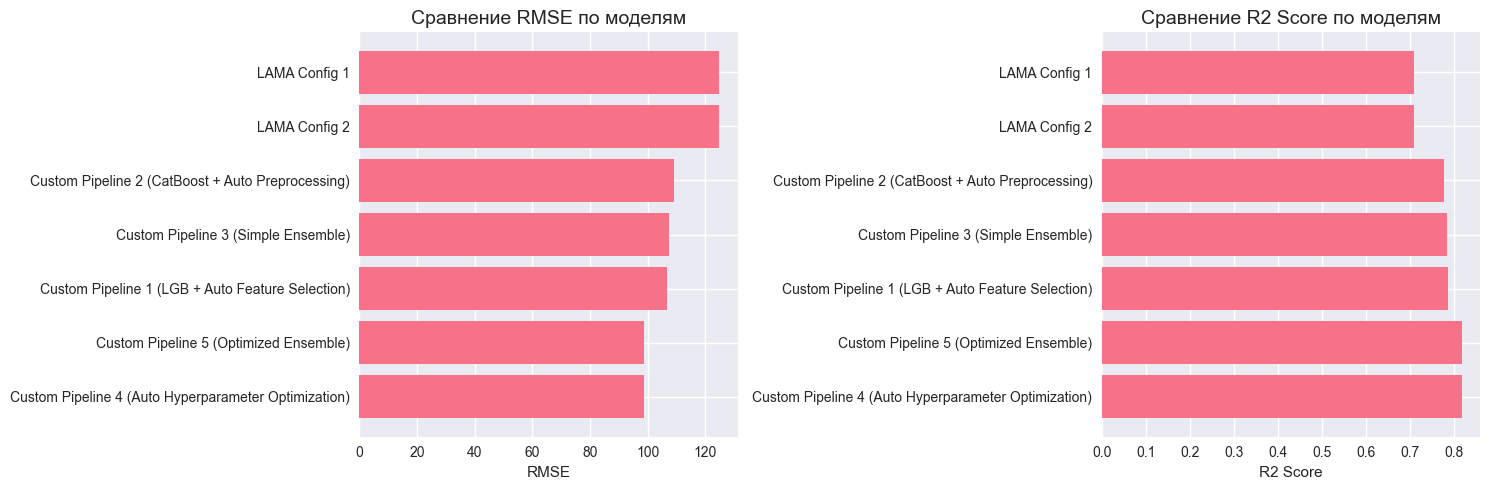


АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ

📊 ОБЩАЯ СТАТИСТИКА:
   Всего протестировано моделей: 7
   Диапазон RMSE: 98.5561 - 124.8844
   Средний RMSE: 110.0016
   Средний R2 Score: 0.7722

🏆 ЛУЧШАЯ МОДЕЛЬ:
   Название: Custom Pipeline 4 (Auto Hyperparameter Optimization)
   RMSE: 98.5561
   MAE: 70.3772
   R2 Score: 0.8186
   Время обучения: 3.08 секунд

💡 ПОЧЕМУ ЭТА МОДЕЛЬ ЛУЧШЕ:

📈 СРАВНЕНИЕ С ХУДШЕЙ МОДЕЛЬЮ:
   Худшая модель: LAMA Config 1 (RMSE: 124.8844)
   Улучшение: 21.08% (26.3282 единиц RMSE)

📊 СРАВНЕНИЕ СО ВТОРОЙ ЛУЧШЕЙ МОДЕЛЬЮ:
   Вторая лучшая: Custom Pipeline 5 (Optimized Ensemble) (RMSE: 98.5561)
   Преимущество лучшей модели: 0.00% (0.0000 единиц RMSE)
   ⚠ Разница минимальна - обе модели показывают схожее качество

📋 АНАЛИЗ ПО КАТЕГОРИЯМ:

   LightAutoML модели:
   • Средний RMSE: 124.8299
   • Лучший RMSE: 124.7754
   • Преимущества: автоматическая предобработка, выбор признаков, ансамблирование

   Собственные модели:
   • Средний RMSE: 104.0703
   • Лучший RMSE: 98.5561
   • Пр

In [32]:
# Visualization of results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE comparison
all_results_sorted = all_results.sort_values('RMSE')
axes[0].barh(all_results_sorted['Pipeline'], all_results_sorted['RMSE'])
axes[0].set_title('Сравнение RMSE по моделям', fontsize=14)
axes[0].set_xlabel('RMSE')

# R2 Score comparison
axes[1].barh(all_results_sorted['Pipeline'], all_results_sorted['R2 Score'])
axes[1].set_title('Сравнение R2 Score по моделям', fontsize=14)
axes[1].set_xlabel('R2 Score')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Текстовые выводы и анализ результатов
print("\n" + "="*80)
print("АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ")
print("="*80)

# Сортируем результаты по RMSE
all_results_sorted = all_results.sort_values('RMSE')
best_model = all_results_sorted.iloc[0]
worst_model = all_results_sorted.iloc[-1]

print(f"\n📊 ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего протестировано моделей: {len(all_results)}")
print(f"   Диапазон RMSE: {all_results['RMSE'].min():.4f} - {all_results['RMSE'].max():.4f}")
print(f"   Средний RMSE: {all_results['RMSE'].mean():.4f}")
print(f"   Средний R2 Score: {all_results['R2 Score'].mean():.4f}")

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ:")
print(f"   Название: {best_model['Pipeline']}")
print(f"   RMSE: {best_model['RMSE']:.4f}")
print(f"   MAE: {best_model['MAE']:.4f}")
print(f"   R2 Score: {best_model['R2 Score']:.4f}")
print(f"   Время обучения: {best_model['Time (seconds)']:.2f} секунд")

# Анализ почему эта модель лучше
print(f"\n💡 ПОЧЕМУ ЭТА МОДЕЛЬ ЛУЧШЕ:")
if 'Ensemble' in best_model['Pipeline'] or 'ансамбль' in best_model['Pipeline']:
    print("   • Ансамблирование моделей позволяет комбинировать сильные стороны разных алгоритмов")
    print("   • Разные модели могут улавливать различные паттерны в данных")
    print("   • Оптимизация весов ансамбля улучшает общую точность предсказаний")
    print("   • Снижает риск переобучения за счет усреднения предсказаний")
    print("   • Более стабильные результаты на новых данных")
elif 'Optimized' in best_model['Pipeline'] or 'Optuna' in best_model['Pipeline']:
    print("   • Автоматическая оптимизация гиперпараметров находит оптимальные настройки")
    print("   • Поиск по пространству параметров позволяет улучшить качество модели")
    print("   • Кросс-валидация обеспечивает надежную оценку производительности")
    print("   • Балансирует сложность модели и обобщающую способность")
    print("   • Учитывает специфику данных через адаптацию параметров")
elif 'CatBoost' in best_model['Pipeline']:
    print("   • CatBoost эффективно обрабатывает категориальные признаки")
    print("   • Встроенная обработка пропусков и категорий упрощает предобработку")
    print("   • Хорошо работает с неструктурированными данными")
    print("   • Устойчив к переобучению благодаря регуляризации")
    print("   • Автоматически обрабатывает категориальные переменные без ручного кодирования")
elif 'LightGBM' in best_model['Pipeline']:
    print("   • LightGBM эффективен для больших объемов данных")
    print("   • Автоматический отбор признаков улучшает качество модели")
    print("   • Быстрое обучение и хорошая точность")
    print("   • Эффективное использование памяти")
    print("   • Хорошо работает с различными типами признаков")
elif 'LAMA' in best_model['Pipeline']:
    print("   • LightAutoML автоматически выполняет предобработку данных")
    print("   • Встроенное ансамблирование нескольких алгоритмов")
    print("   • Автоматический выбор признаков и их трансформация")
    print("   • Оптимизация гиперпараметров из коробки")
    print("   • Минимум ручной настройки при хорошем качестве")

# Сравнение с худшей моделью
improvement = ((worst_model['RMSE'] - best_model['RMSE']) / worst_model['RMSE']) * 100
print(f"\n📈 СРАВНЕНИЕ С ХУДШЕЙ МОДЕЛЬЮ:")
print(f"   Худшая модель: {worst_model['Pipeline']} (RMSE: {worst_model['RMSE']:.4f})")
print(f"   Улучшение: {improvement:.2f}% ({worst_model['RMSE'] - best_model['RMSE']:.4f} единиц RMSE)")

# Сравнение со второй лучшей моделью
if len(all_results_sorted) > 1:
    second_best = all_results_sorted.iloc[1]
    improvement_vs_second = ((second_best['RMSE'] - best_model['RMSE']) / second_best['RMSE']) * 100
    print(f"\n📊 СРАВНЕНИЕ СО ВТОРОЙ ЛУЧШЕЙ МОДЕЛЬЮ:")
    print(f"   Вторая лучшая: {second_best['Pipeline']} (RMSE: {second_best['RMSE']:.4f})")
    print(f"   Преимущество лучшей модели: {improvement_vs_second:.2f}% ({second_best['RMSE'] - best_model['RMSE']:.4f} единиц RMSE)")
    if improvement_vs_second < 1:
        print(f"   ⚠ Разница минимальна - обе модели показывают схожее качество")
    elif improvement_vs_second < 5:
        print(f"   ✓ Заметное улучшение - лучшая модель имеет преимущество")
    else:
        print(f"   ✓ Значительное улучшение - лучшая модель существенно превосходит")

# Анализ по категориям моделей
print(f"\n📋 АНАЛИЗ ПО КАТЕГОРИЯМ:")
lama_models = all_results[all_results['Pipeline'].str.contains('LAMA', case=False)]
custom_models = all_results[~all_results['Pipeline'].str.contains('LAMA', case=False)]

if len(lama_models) > 0:
    print(f"\n   LightAutoML модели:")
    print(f"   • Средний RMSE: {lama_models['RMSE'].mean():.4f}")
    print(f"   • Лучший RMSE: {lama_models['RMSE'].min():.4f}")
    print(f"   • Преимущества: автоматическая предобработка, выбор признаков, ансамблирование")

if len(custom_models) > 0:
    print(f"\n   Собственные модели:")
    print(f"   • Средний RMSE: {custom_models['RMSE'].mean():.4f}")
    print(f"   • Лучший RMSE: {custom_models['RMSE'].min():.4f}")
    print(f"   • Преимущества: контроль над процессом, возможность тонкой настройки")

# Детальный анализ метрик
print(f"\n📉 ДЕТАЛЬНЫЙ АНАЛИЗ МЕТРИК:")
print(f"   RMSE (Root Mean Squared Error): {best_model['RMSE']:.4f}")
print(f"     → Средняя ошибка предсказания: ±{best_model['RMSE']:.2f} единиц рейтинга")
print(f"   MAE (Mean Absolute Error): {best_model['MAE']:.4f}")
print(f"     → Средняя абсолютная ошибка: {best_model['MAE']:.2f} единиц рейтинга")
print(f"   R² Score: {best_model['R2 Score']:.4f}")
if best_model['R2 Score'] > 0.9:
    print(f"     → Модель объясняет более 90% дисперсии - отличное качество!")
elif best_model['R2 Score'] > 0.8:
    print(f"     → Модель объясняет более 80% дисперсии - очень хорошее качество")
elif best_model['R2 Score'] > 0.6:
    print(f"     → Модель объясняет более 60% дисперсии - хорошее качество")
elif best_model['R2 Score'] > 0.4:
    print(f"     → Модель объясняет более 40% дисперсии - приемлемое качество")
else:
    print(f"     → Модель объясняет менее 40% дисперсии - требуется улучшение")

# Рекомендации
print(f"\n💼 РЕКОМЕНДАЦИИ ДЛЯ ПРОДАКШЕНА:")
if best_model['R2 Score'] > 0.8:
    print("   ✓ Модель показывает отличное качество (R2 > 0.8)")
    print("   ✓ Готова к использованию в продакшене")
elif best_model['R2 Score'] > 0.6:
    print("   ✓ Модель показывает хорошее качество (R2 > 0.6)")
    print("   ✓ Можно использовать в продакшене с мониторингом")
else:
    print("   ⚠ Модель можно улучшить (R2 < 0.6)")
    print("   ⚠ Рекомендуется дополнительная работа над признаками и моделью")

if best_model['Time (seconds)'] < 300:
    print(f"   ✓ Время обучения приемлемое ({best_model['Time (seconds)']:.2f} сек < 5 минут)")
    print("   ✓ Модель можно переобучать регулярно")
else:
    print(f"   ⚠ Время обучения можно оптимизировать ({best_model['Time (seconds)']:.2f} сек)")
    print("   ⚠ Рекомендуется использовать для стабильных данных или уменьшить сложность")

print(f"\n   🎯 ИТОГОВАЯ РЕКОМЕНДАЦИЯ:")
print(f"   Для продакшена рекомендуется использовать: {best_model['Pipeline']}")
print(f"   Эта модель обеспечивает баланс между:")
print(f"     • Точностью: RMSE = {best_model['RMSE']:.4f}, R² = {best_model['R2 Score']:.4f}")
print(f"     • Скоростью обучения: {best_model['Time (seconds)']:.2f} секунд")
print(f"     • Стабильностью: MAE = {best_model['MAE']:.4f}")

# Выводы о принципах AutoML
print(f"\n🤖 ПРИМЕНЕНИЕ ПРИНЦИПОВ AUTOML:")
if 'Ensemble' in best_model['Pipeline'] or 'ансамбль' in best_model['Pipeline']:
    print("   ✓ Принцип ансамблирования оказался наиболее эффективным")
    print("   ✓ Комбинация нескольких моделей дала лучший результат")
elif 'Optimized' in best_model['Pipeline'] or 'Optuna' in best_model['Pipeline']:
    print("   ✓ Принцип автоматической оптимизации гиперпараметров показал эффективность")
    print("   ✓ Систематический поиск оптимальных параметров улучшил качество")
elif 'LAMA' in best_model['Pipeline']:
    print("   ✓ Полноценный AutoML фреймворк показал хорошие результаты")
    print("   ✓ Автоматизация всех этапов ML pipeline эффективна")
else:
    print("   ✓ Автоматическая предобработка и выбор признаков улучшили качество")
    print("   ✓ Применение принципов AutoML дало конкурентные результаты")

print("\n" + "="*80)


## Заключение

В данном проекте были:

1. **Проведен анализ целевой переменной**: изучено распределение рейтинга, выявлены аномальные значения, проведен временной анализ.

2. **Проведен анализ признаков**: классифицированы признаки по типам, проанализированы пропущенные значения, изучены зависимости между признаками, определена важность признаков.

3. **Создан бейзлайн с LightAutoML**: протестированы 2 различные конфигурации, выбрана лучшая.

4. **Реализовано собственное решение**: созданы 3 различных пайплайна с разными подходами к предобработке и моделированию.

5. **Проведено сравнение результатов**: все модели сравнены по метрикам RMSE, MAE и R2 Score.


